<a href="https://colab.research.google.com/github/namwootree/Study-in-UNIST/blob/main/%EA%B3%84%EB%9F%89%EA%B2%BD%EC%A0%9C%ED%95%99/Final_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting

In [1]:
import pandas as pd
import numpy as np
import math
from scipy.stats import shapiro, kstest, levene, ttest_ind

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import statsmodels.api as sm

In [4]:
from tqdm.notebook import tqdm

In [5]:
from importlib import reload
plt=reload(plt)

In [6]:
pd.options.display.float_format = '{:.4f}'.format

# Load Data Set

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
path = '/content/gdrive/MyDrive/UNIST/계량 경제학/march_cps.csv'
data = pd.read_csv(path)
data = data.drop(columns=['Unnamed: 0'])

# Preprocessing

In [9]:
data['log_weekly_earn'] = data['weekly_earn'].apply(lambda x : math.log10(x))
data['log_hourly_wage'] = data['hourly_wage'].apply(lambda x : math.log10(x))

In [10]:
cond_v = (data['veteran']==1)
cond_g = (data['college_grad']==1)

data.loc[(cond_v & cond_g), 'veteran_grad'] = 1
data.loc[~(cond_v & cond_g), 'veteran_grad'] = 0

In [11]:
cond_f = (data['female']==1)
cond_g = (data['college_grad']==1)

data.loc[(cond_f & cond_g), 'female_grad'] = 1
data.loc[~(cond_f & cond_g), 'female_grad'] = 0

In [13]:
cond_marry = (data['marital_status']==1)

data.loc[cond_marry, 'marital_status'] = 1
data.loc[~cond_marry, 'marital_status'] = 0 

In [12]:
cond_full = (data['uhrswork']>=40)
data.loc[cond_full, 'full_time'] = 1
data.loc[~cond_full, 'full_time'] = 0

In [14]:
data['veteran_grad'] = data['veteran_grad'].astype('int64')
data['full_time'] = data['full_time'].astype('int64')
data['female_grad'] = data['female_grad'].astype('int64')
data['marital_status'] = data['marital_status'].astype('int64')

# Modeling

In [85]:
  y = 'log_weekly_earn'
  x = ['C(college_grad)', 'C(female)', 'C(marital_status)', 'C(full_time)', 'C(veteran)',  'C(female_grad)', 'C(veteran_grad)']
  x = ' + '.join(x)
  formula = y + ' ~ ' + x
  regression = sm.OLS.from_formula(formula, data=data).fit()

In [92]:
list(pd.read_html(regression.summary().tables[2].as_html())[0][3])[-1]

13.1

In [93]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [97]:
from patsy import dmatrices

In [181]:
dfy, dfX = dmatrices(formula, data, return_type = 'dataframe')

In [182]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(dfX.values, i) for i in range(dfX.shape[1])]
vif.T

,0,1,2,3,4,5,6,7
VIF Factor,16.8231,2.1553,2.1626,1.0183,1.0510,1.7998,2.8469,1.8167


In [186]:
VIF = pd.DataFrame()
VIF = pd.concat([VIF, vif.T])
VIF.columns = ['Intercept', 'college_grad', 'female', 'marital_status', 'full_time', 'veteran', 'female * grad', 'veteran * grad']

In [188]:
VIF

,Intercept,college_grad,female,marital_status,full_time,veteran,female * grad,veteran * grad
VIF Factor,16.8231,2.1553,2.1626,1.0183,1.0510,1.7998,2.8469,1.8167


In [86]:
print(regression.summary())

                            OLS Regression Results                            
Dep. Variable:        log_weekly_earn   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                 4.156e+04
Date:                Tue, 06 Jun 2023   Prob (F-statistic):               0.00
Time:                        12:52:55   Log-Likelihood:                -75490.
No. Observations:              870825   AIC:                         1.510e+05
Df Residuals:                  870817   BIC:                         1.511e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  2

In [117]:
(0.2527-0.1009)/0.1009*100

150.4459861248761

In [119]:
(0.2297-0.0829)/0.0829*100

177.08082026537994

In [189]:
def regression_analysis(data, target, top_level=None, bottom_level=None, summary=False, plot_politics=True):

  list_year = []
  list_R2 = []
  list_R2_adj = []
  list_grad_tvalue = []

  list_grad_025 = []
  list_grad_975 = []

  list_female_grad_025 = []
  list_female_grad_975 = []

  list_veteran_grad_025 = []
  list_veteran_grad_975 = []

  y = target
  x = ['C(college_grad)', 'C(female)', 'C(marital_status)', 'C(full_time)', 'C(veteran)',  'C(female_grad)', 'C(veteran_grad)']
  x = ' + '.join(x)
  formula = y + ' ~ ' + x


  if top_level != None:
    print(f'데이터셋 : {target} 상위 {top_level}%')
  elif bottom_level != None:
    print(f'데이터셋 : {target} 하위 {bottom_level}%')
  else:
    print(f'데이터셋 : {target} 100%')

  print(f'\n회귀식 : {formula}\n')

  result = pd.DataFrame()
  VIF = pd.DataFrame()

  for year in tqdm(data['year'].unique()):
    cond_year = (data['year']==year)
    data_year = data.loc[cond_year]

    dfy, dfX = dmatrices(formula, data_year, return_type = 'dataframe')
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(dfX.values, i) for i in range(dfX.shape[1])]
    VIF = pd.concat([VIF, vif.T])

    if top_level != None:
      cond_top = (data_year[target] >= data_year[target].quantile(1-top_level))
      data_year = data_year.loc[cond_top]

    if bottom_level != None:
      cond_bottom = (data_year[target] <= data_year[target].quantile(bottom_level))
      data_year = data_year.loc[cond_bottom]

    if top_level == None and bottom_level == None:
      pass
    
    regression = sm.OLS.from_formula(formula, data=data_year).fit()

    if summary == True:
      print(f'\n{year}년 Linear Regression\n')
      print(regression.summary())
      print('\n\n')

    list_year.append(year)
    list_R2.append(regression.rsquared)
    list_R2_adj.append(regression.rsquared_adj)

    list_grad_025.append(regression.conf_int().iloc[1][0])
    list_grad_975.append(regression.conf_int().iloc[1][1])

    list_female_grad_025.append(regression.conf_int().iloc[6][0])
    list_female_grad_975.append(regression.conf_int().iloc[6][1])

    list_veteran_grad_025.append(regression.conf_int().iloc[7][0])
    list_veteran_grad_975.append(regression.conf_int().iloc[7][1])

    list_grad_tvalue.append(regression.tvalues[1])

    param = pd.DataFrame(regression.params).T
    result = pd.concat([result, param], axis=0)

  VIF.columns = ['Intercept', 'college_grad', 'female', 'marital_status', 'full_time', 'veteran', 'female * grad', 'veteran * grad']
  VIF.index = list_year
  
  print(f'데이터셋 크기 : {data_year.shape[0]}\n')
  result.index = list_year
  result['R2'] = list_R2
  result['R2_adj'] = list_R2_adj
  result['college_grad_tvalue'] = list_grad_tvalue

  result['college_grad_ci_025'] = list_grad_025
  result['college_grad_ci_975'] = list_grad_975

  result['college_female_grad_ci_025'] = list_female_grad_025
  result['college_female_grad_ci_975'] = list_female_grad_975

  result['college_veteran_grad_ci_025'] = list_veteran_grad_025
  result['college_veteran_grad_ci_975'] = list_veteran_grad_975

  result.columns =   ['Intercept',  'college_grad', 'female', 'marital_status', 'full_time', 'veteran',
                      'female * grad', 'veteran * grad',
                      'R2', 'R2_adj', 'college_grad_tvalue',
                      'college_grad_ci_025', 'college_grad_ci_975',
                      'college_female_grad_ci_025', 'college_female_grad_ci_975',
                      'college_veteran_grad_ci_025', 'college_veteran_grad_ci_975']

  plt.figure(figsize=(13,8))
  plt.title('Trends in the coefficients of each variable in a linear model')
  for col in ['college_grad', 'female', 'marital_status', 'full_time', 'veteran', 'female * grad', 'veteran * grad']:

     sns.lineplot(data=result,
                  x=result.index,
                  y=col,
                  label=col)
  if plot_politics == True:
    plt.axvspan(1974, 1976, facecolor='red', alpha=0.1, label = 'the Republican Party')
    plt.axvspan(1977, 1980, facecolor='blue', alpha=0.1, label='the Democratic Party')
    plt.axvspan(1981, 1988, facecolor='red', alpha=0.1)
    plt.axvspan(1989, 1992, facecolor='red', alpha=0.1)
    plt.axvspan(1993, 2000, facecolor='blue', alpha=0.1)
    plt.axvspan(2001, 2008, facecolor='red', alpha=0.1)
    plt.axvspan(2009, 2015, facecolor='blue', alpha=0.1)

  plt.xticks([1974 + i*6 for i in range(7)])
  plt.xlabel('YEAR')
  plt.ylabel('BETA')
  plt.legend()
  plt.show()
  print()
  
  college_grad_mean = np.mean(result['college_grad'])
  college_grad_std = math.sqrt(np.var(result['college_grad']))
  college_grad_max = np.max(result['college_grad'])
  college_grad_min = np.min(result['college_grad'])

  print(f'mean : {college_grad_mean}')
  print(f'std : {college_grad_std}')
  print(f'max : {college_grad_max}')
  print(f'min : {college_grad_min}')

  plt.figure(figsize=(13,8))
  plt.title('College Graduate Premium Trends')
  sns.lineplot(data=result, x=result.index, y="college_grad", color='darkblue')
  for year, min_ci, max_ci in zip(result.index, result['college_grad_ci_025'], result['college_grad_ci_975']):
    plt.vlines(year, min_ci, max_ci, color='darkblue', linestyle='solid', linewidth=2)

  if plot_politics == True:
    plt.axvspan(1974, 1976, facecolor='red', alpha=0.1, label = 'the Republican Party')
    plt.axvspan(1977, 1980, facecolor='blue', alpha=0.1, label='the Democratic Party')
    plt.axvspan(1981, 1988, facecolor='red', alpha=0.1)
    plt.axvspan(1989, 1992, facecolor='red', alpha=0.1)
    plt.axvspan(1993, 2000, facecolor='blue', alpha=0.1)
    plt.axvspan(2001, 2008, facecolor='red', alpha=0.1)
    plt.axvspan(2009, 2015, facecolor='blue', alpha=0.1)

  plt.xticks([1974 + i*6 for i in range(7)])
  plt.xlabel('YEAR')
  plt.ylabel('BETA of College Graduate Premium')
  plt.legend()
  plt.show()
  print()

  plt.figure(figsize=(13,8))
  plt.title('College Female * Graduate Premium Trends')
  sns.lineplot(data=result, x=result.index, y="female * grad", color='darkblue')
  for year, min_ci, max_ci in zip(result.index, result['college_female_grad_ci_025'], result['college_female_grad_ci_975']):
    plt.vlines(year, min_ci, max_ci, color='darkblue', linestyle='solid', linewidth=2)

  if plot_politics == True:
    plt.axvspan(1974, 1976, facecolor='red', alpha=0.1, label = 'the Republican Party')
    plt.axvspan(1977, 1980, facecolor='blue', alpha=0.1, label='the Democratic Party')
    plt.axvspan(1981, 1988, facecolor='red', alpha=0.1)
    plt.axvspan(1989, 1992, facecolor='red', alpha=0.1)
    plt.axvspan(1993, 2000, facecolor='blue', alpha=0.1)
    plt.axvspan(2001, 2008, facecolor='red', alpha=0.1)
    plt.axvspan(2009, 2015, facecolor='blue', alpha=0.1)

  plt.xticks([1974 + i*6 for i in range(7)])
  plt.xlabel('YEAR')
  plt.ylabel('BETA of College Female * Graduate Premium')
  plt.legend()
  plt.show()
  print()

  plt.figure(figsize=(13,8))
  plt.title('College Veteran * Graduate Premium Trends')
  sns.lineplot(data=result, x=result.index, y="veteran * grad", color='darkblue')
  for year, min_ci, max_ci in zip(result.index, result['college_veteran_grad_ci_025'], result['college_veteran_grad_ci_975']):
    plt.vlines(year, min_ci, max_ci, color='darkblue', linestyle='solid', linewidth=2)

  if plot_politics == True:
    plt.axvspan(1974, 1976, facecolor='red', alpha=0.1, label = 'the Republican Party')
    plt.axvspan(1977, 1980, facecolor='blue', alpha=0.1, label='the Democratic Party')
    plt.axvspan(1981, 1988, facecolor='red', alpha=0.1)
    plt.axvspan(1989, 1992, facecolor='red', alpha=0.1)
    plt.axvspan(1993, 2000, facecolor='blue', alpha=0.1)
    plt.axvspan(2001, 2008, facecolor='red', alpha=0.1)
    plt.axvspan(2009, 2015, facecolor='blue', alpha=0.1)

  plt.xticks([1974 + i*6 for i in range(7)])
  plt.xlabel('YEAR')
  plt.ylabel('BETA of College Veteran * Graduate Premium')
  plt.legend()
  plt.show()
  print()

  plt.figure(figsize=(13,8))
  plt.title('R-squred of the linear model for each year')
  sns.lineplot(data=result, x=result.index, y="R2")
  plt.xlabel('YEAR')
  plt.ylabel('R-squared')
  plt.show()

  result =  result.reset_index()
  result.rename(columns={'index':'year'}, inplace=True)
  cond_1_republican = (result['year']>=1974) & (result['year']<1977) # 제럴드 포드 (공화당)
  cond_2_republican = (result['year']>=1977) & (result['year']<1981) # 지미 카터 (민주당)
  cond_3_republican = (result['year']>=1981) & (result['year']<1989) # 로널드 레이건 (공화당)
  cond_4_republican = (result['year']>=1989) & (result['year']<1993) # 조지 부시 (공화당)
  cond_5_republican = (result['year']>=1993) & (result['year']<2001) # 빌 클린턴 (민주당)
  cond_6_republican = (result['year']>=2001) & (result['year']<2009) # 조지 부시 (공화당)
  cond_7_republican = (result['year']>=2009) & (result['year']<2016) # 버락 오바마 (민주당)

  result.loc[cond_1_republican, 'The_Republican_Part'] = 1
  result.loc[cond_2_republican, 'The_Republican_Part'] = 0
  result.loc[cond_3_republican, 'The_Republican_Part'] = 1
  result.loc[cond_4_republican, 'The_Republican_Part'] = 1
  result.loc[cond_5_republican, 'The_Republican_Part'] = 0
  result.loc[cond_6_republican, 'The_Republican_Part'] = 1
  result.loc[cond_7_republican, 'The_Republican_Part'] = 0
  result['The_Republican_Part'] = result['The_Republican_Part'].astype('int64')

  print()
  plt.figure(figsize=(13,8))
  plt.title('beta distribution of college graduation status')
  sns.histplot(data=result,
             x='college_grad',
             hue='The_Republican_Part',
             element="step",
             palette=['blue', 'red'])
  plt.show()

  return result, VIF

## 모든 데이터

### Log Weekly Earn

데이터셋 : log_weekly_earn 100%

회귀식 : log_weekly_earn ~ C(college_grad) + C(female) + C(marital_status) + C(full_time) + C(veteran) + C(female_grad) + C(veteran_grad)



  0%|          | 0/35 [00:00<?, ?it/s]

데이터셋 크기 : 29253



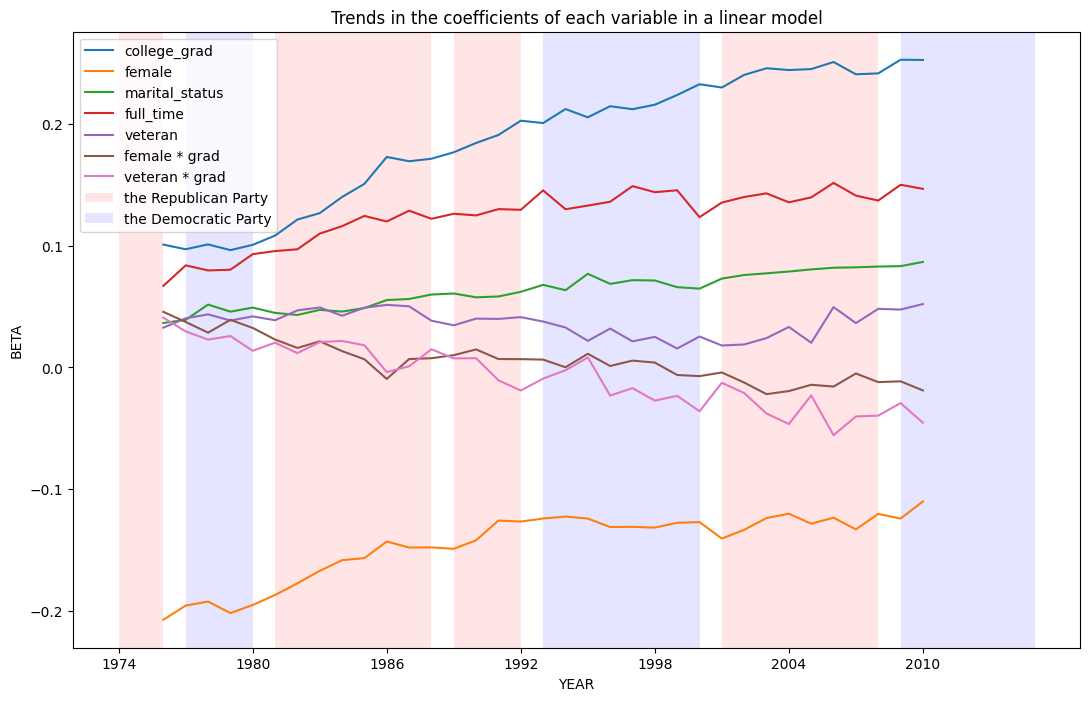


mean : 0.18791393033004328
std : 0.052808639351376745
max : 0.2529127147198727
min : 0.09639965243700582


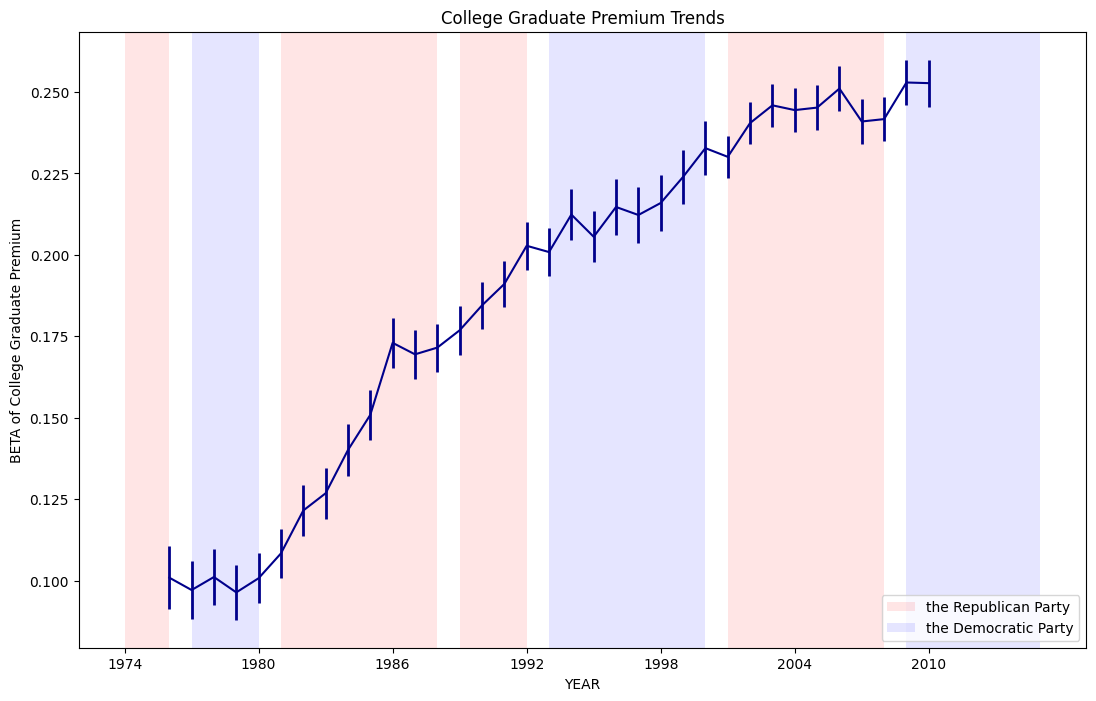

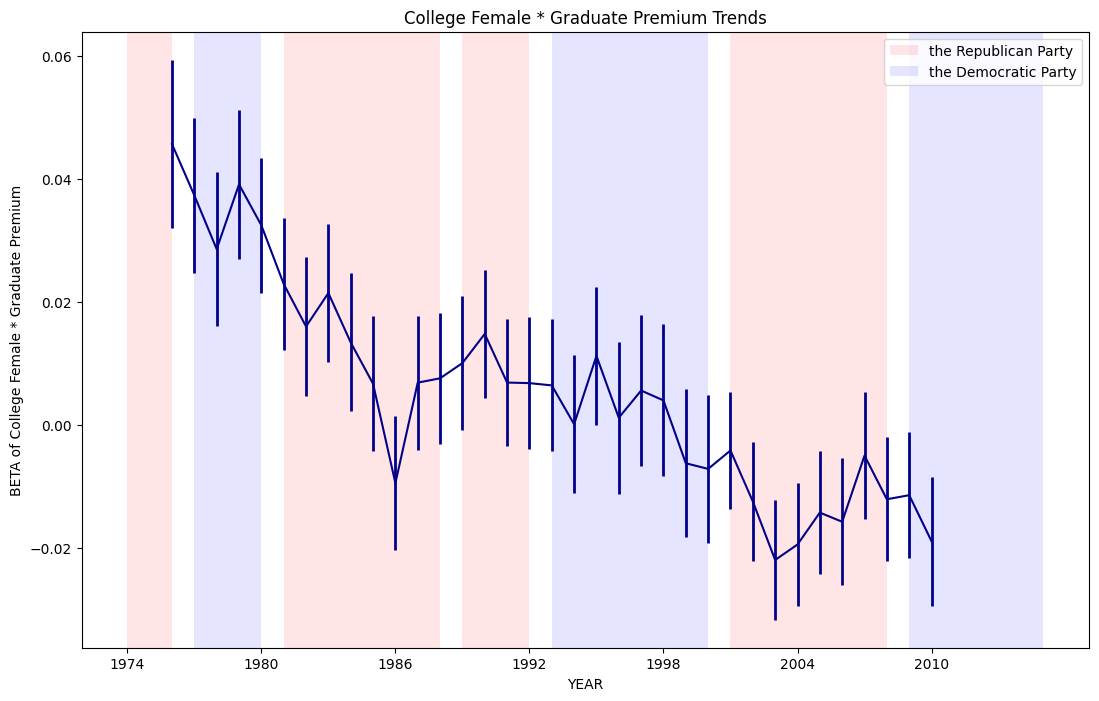

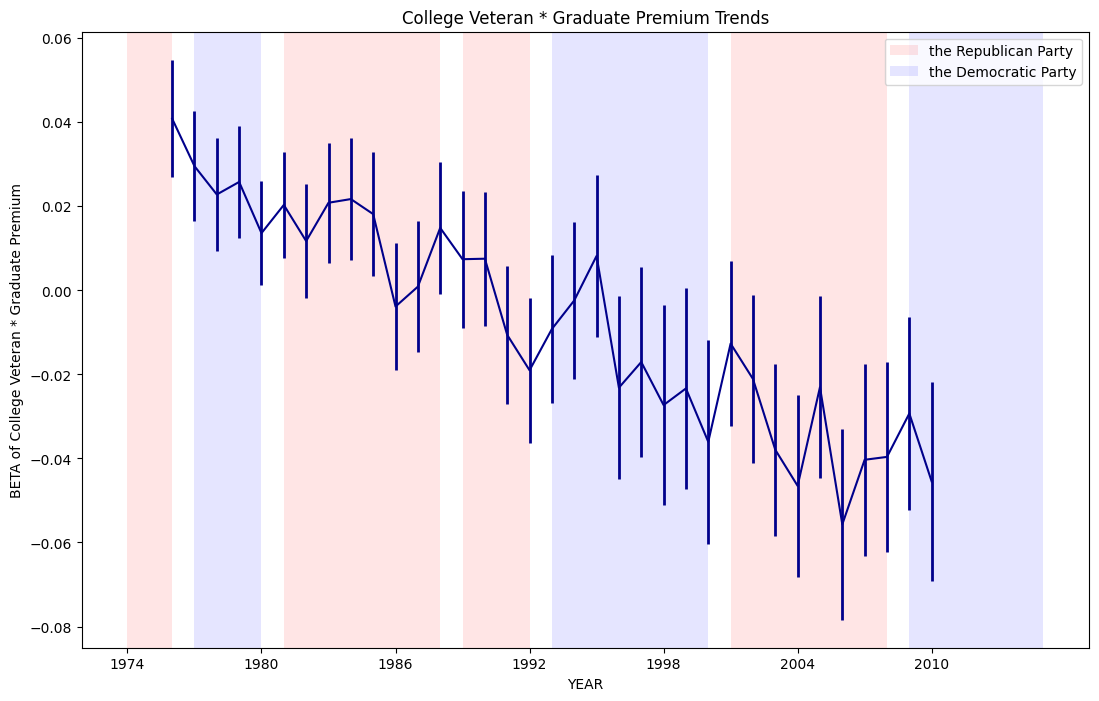

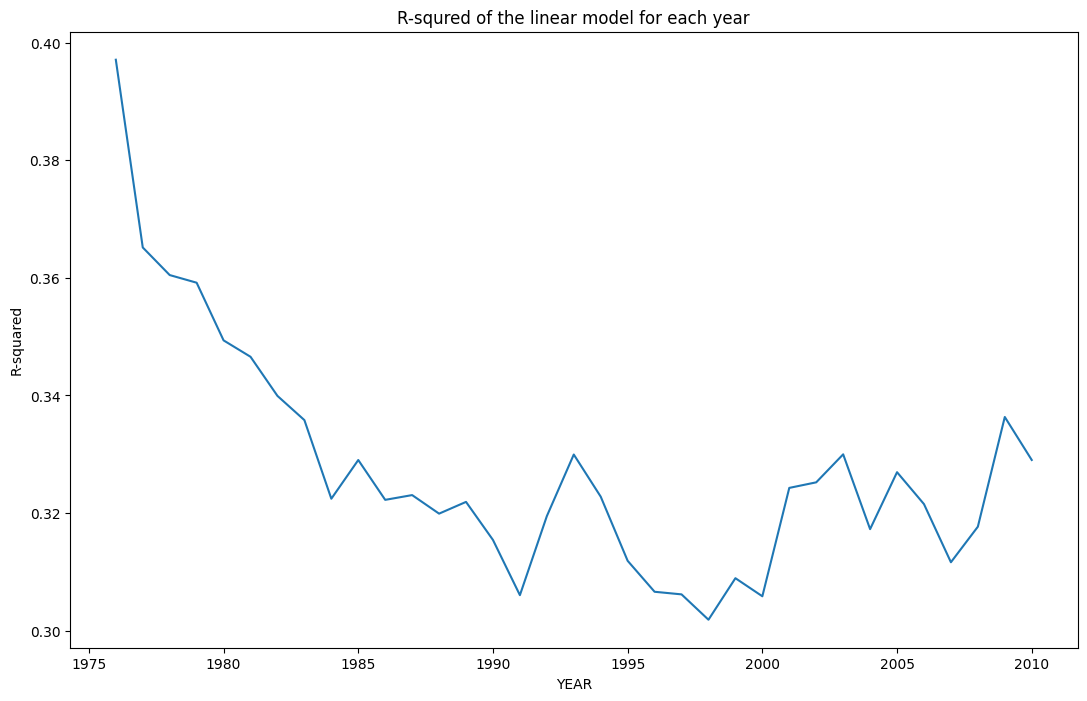

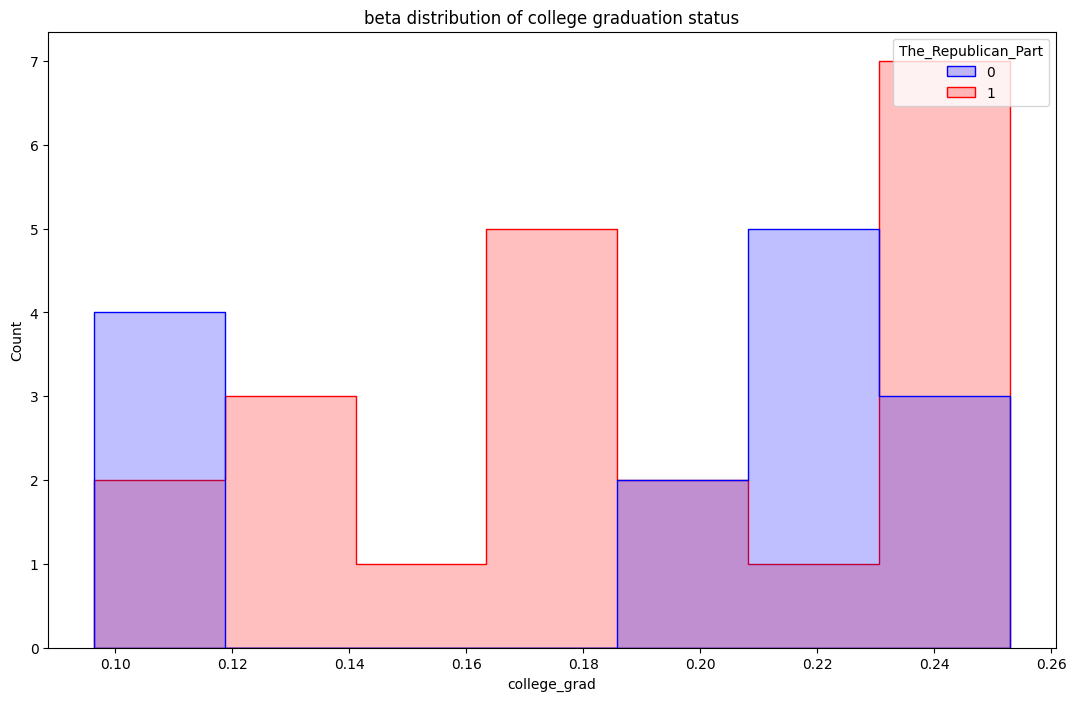

In [190]:
all_log_weekly_earn, all_log_weekly_VIF = regression_analysis(data=data,
                                                              target='log_weekly_earn',
                                                              top_level=None,
                                                              bottom_level=None,
                                                              summary=False)

In [199]:
display(all_log_weekly_VIF)

,Intercept,college_grad,female,marital_status,full_time,veteran,female * grad,veteran * grad
1976,19.7432,2.9315,2.3945,1.0662,1.0744,2.2866,2.5602,2.5355
1977,20.1958,2.8094,2.3390,1.0517,1.0685,2.2364,2.5230,2.4382
1978,19.4417,2.6833,2.2743,1.0547,1.0794,2.1337,2.5186,2.3016
1979,18.6455,2.6045,2.2010,1.0392,1.0702,2.1011,2.4959,2.2866
1980,18.8952,2.5640,2.1809,1.0392,1.0673,2.0609,2.5407,2.2258
1981,18.1068,2.5001,2.1537,1.0371,1.0687,2.0206,2.5244,2.1486
1982,17.3062,2.4187,2.0966,1.0348,1.0590,1.9710,2.4920,2.0862
1983,16.6749,2.4044,2.1475,1.0331,1.0581,1.9783,2.5800,2.0498
1984,16.7089,2.4016,2.1426,1.0271,1.0569,1.9718,2.6473,2.0552
1985,17.1478,2.3547,2.1035,1.0277,1.0564,1.9411,2.6384,2.0339


### Log Hourly wage

데이터셋 : log_hourly_wage 100%

회귀식 : log_hourly_wage ~ C(college_grad) + C(female) + C(marital_status) + C(full_time) + C(veteran) + C(female_grad) + C(veteran_grad)



  0%|          | 0/35 [00:00<?, ?it/s]

데이터셋 크기 : 29253



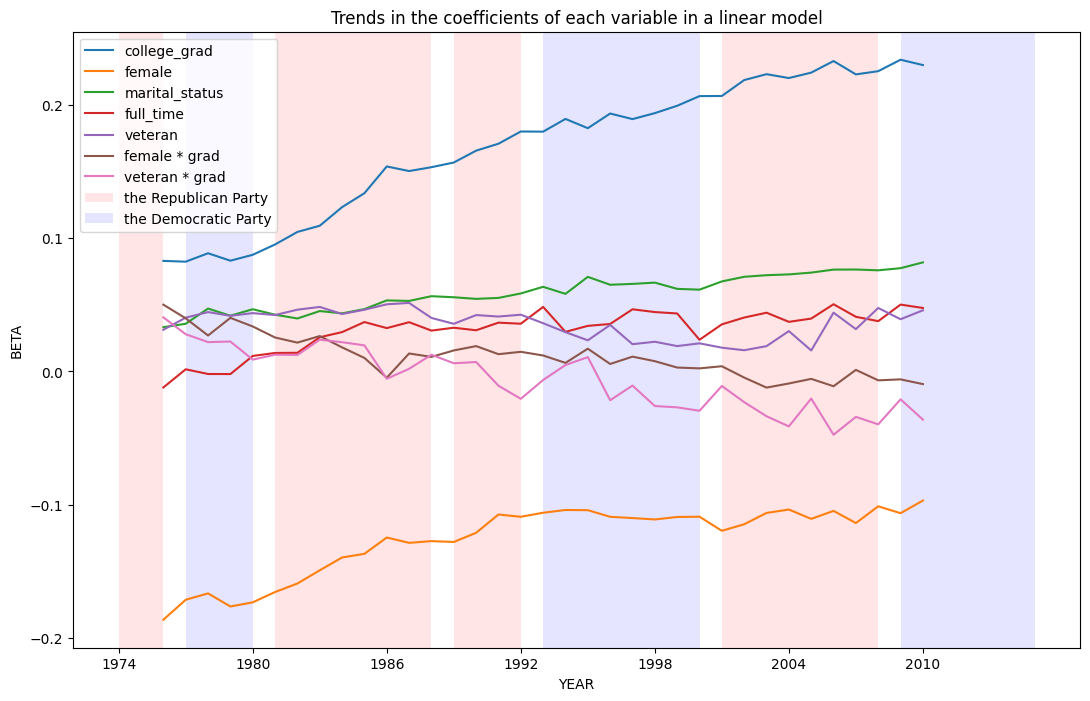


mean : 0.16830113344193628
std : 0.050154431383094084
max : 0.2337518779518534
min : 0.08232731194317332


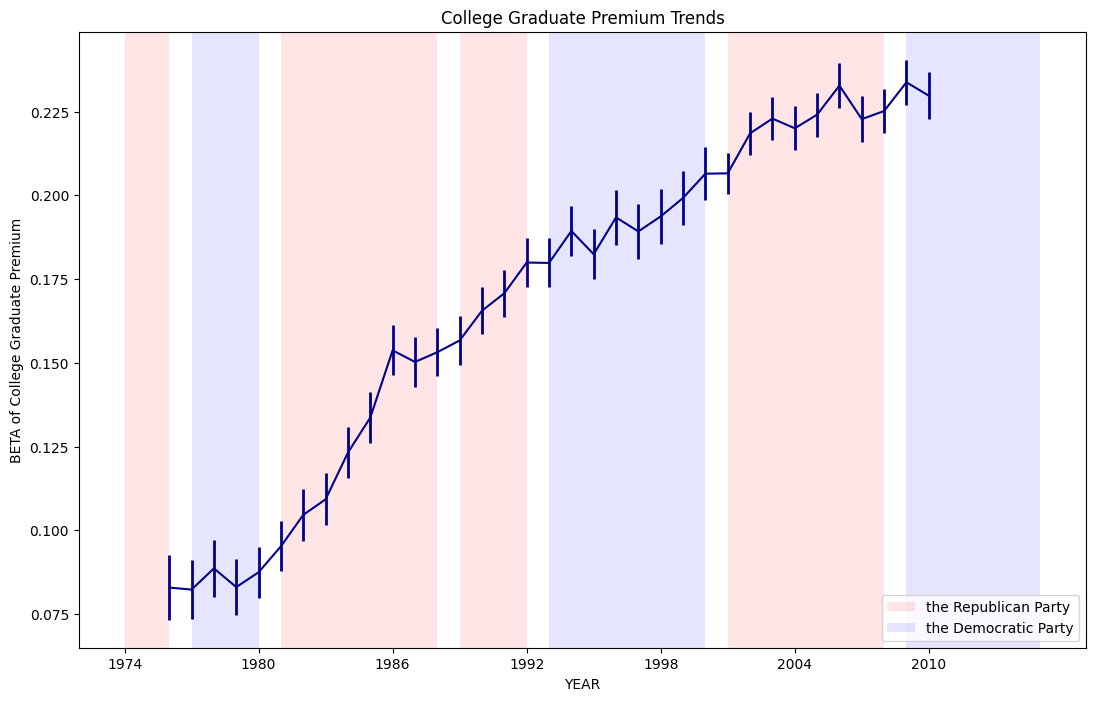

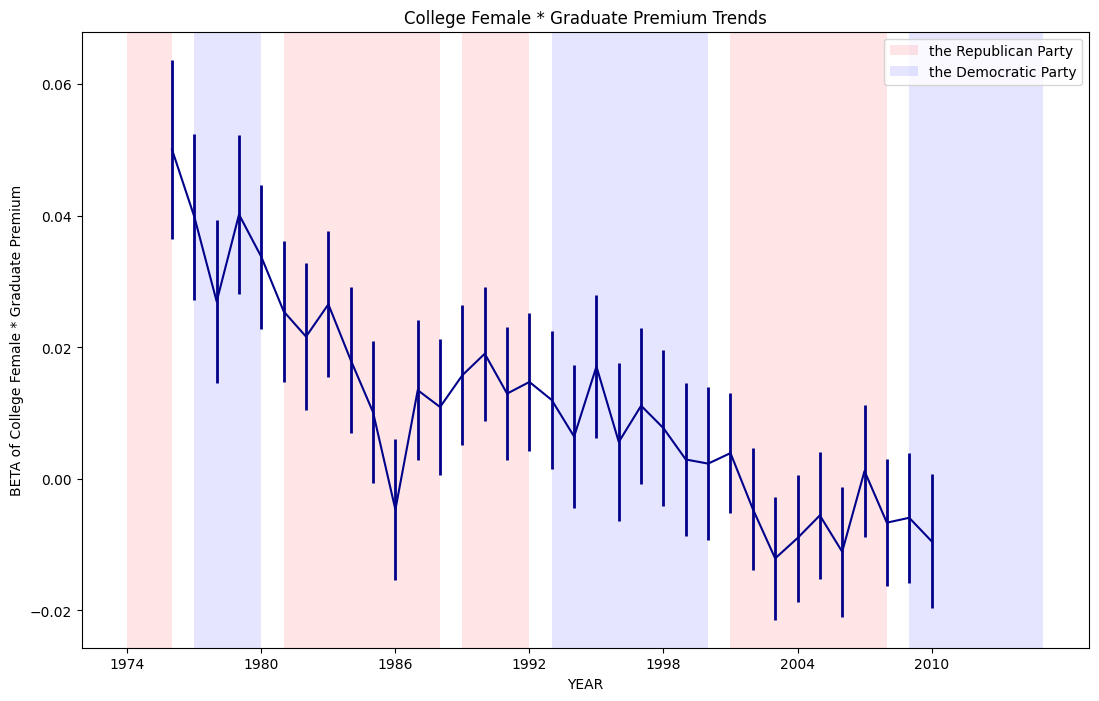

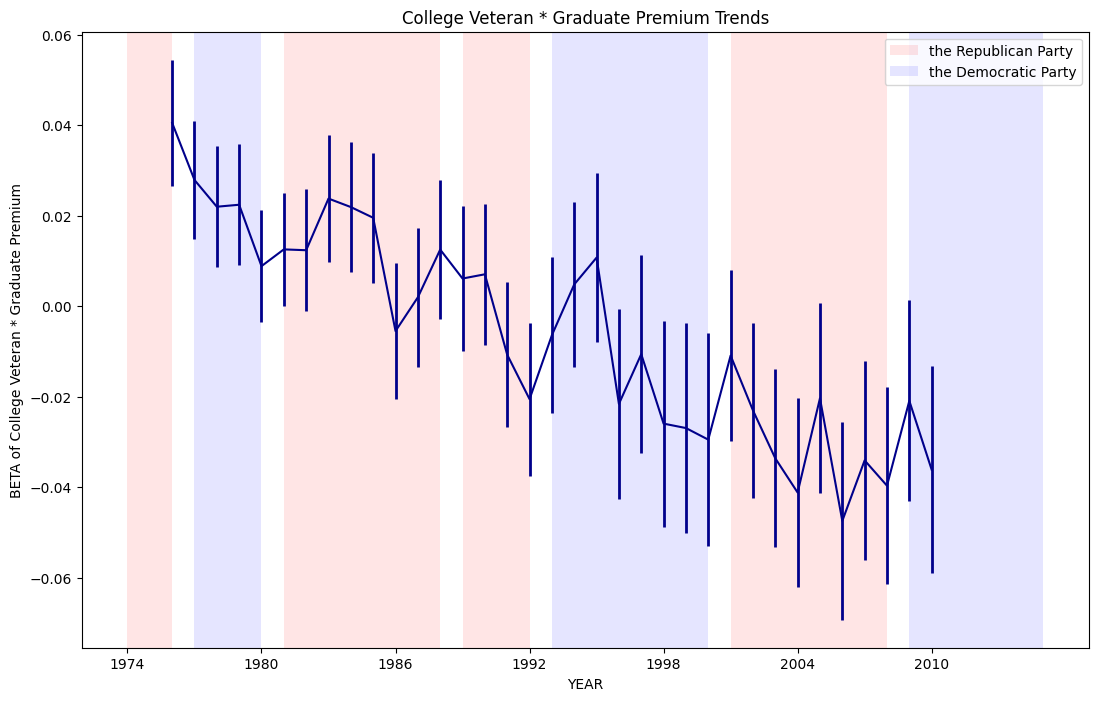

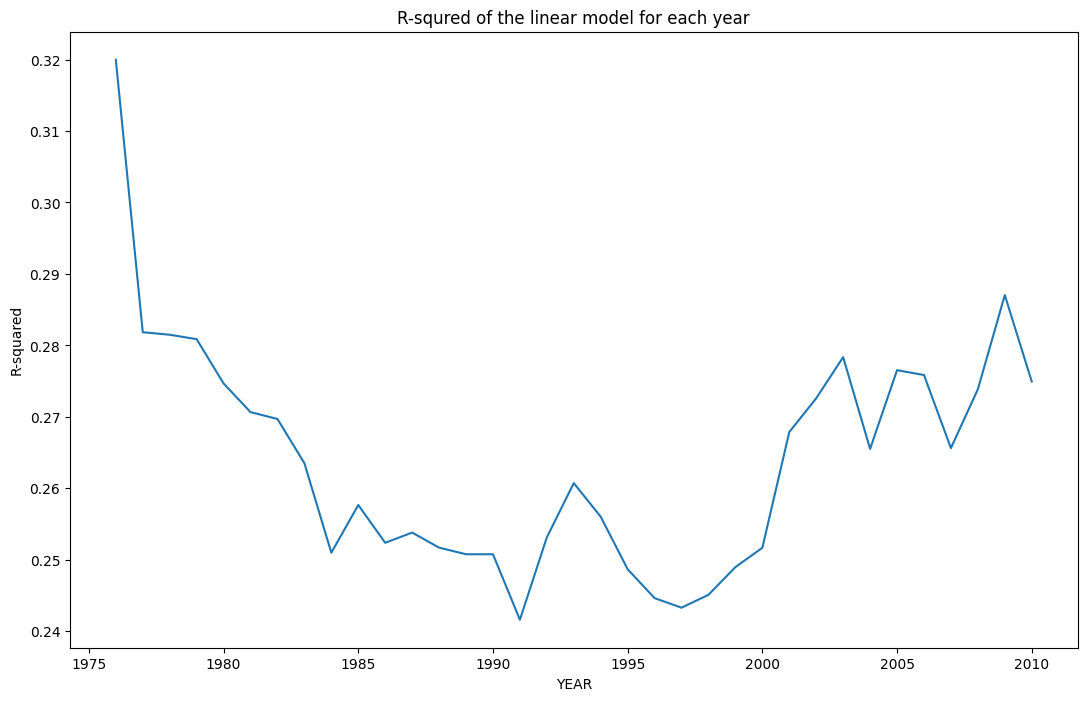

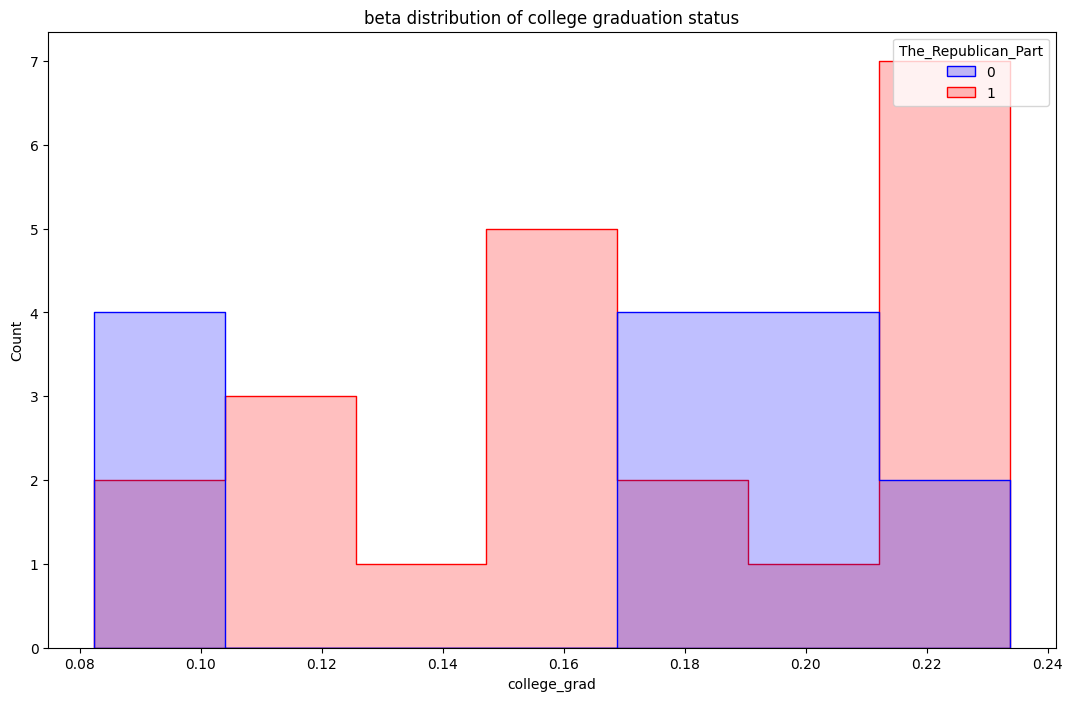

In [193]:
all_log_hourly_wage, all_log_hourly_VIF = regression_analysis(data=data,
                                                              target='log_hourly_wage',
                                                              top_level=None,
                                                              bottom_level=None,
                                                              summary=False)

In [198]:
display(all_log_hourly_VIF)

,Intercept,college_grad,female,marital_status,full_time,veteran,female * grad,veteran * grad
1976,19.7432,2.9315,2.3945,1.0662,1.0744,2.2866,2.5602,2.5355
1977,20.1958,2.8094,2.3390,1.0517,1.0685,2.2364,2.5230,2.4382
1978,19.4417,2.6833,2.2743,1.0547,1.0794,2.1337,2.5186,2.3016
1979,18.6455,2.6045,2.2010,1.0392,1.0702,2.1011,2.4959,2.2866
1980,18.8952,2.5640,2.1809,1.0392,1.0673,2.0609,2.5407,2.2258
1981,18.1068,2.5001,2.1537,1.0371,1.0687,2.0206,2.5244,2.1486
1982,17.3062,2.4187,2.0966,1.0348,1.0590,1.9710,2.4920,2.0862
1983,16.6749,2.4044,2.1475,1.0331,1.0581,1.9783,2.5800,2.0498
1984,16.7089,2.4016,2.1426,1.0271,1.0569,1.9718,2.6473,2.0552
1985,17.1478,2.3547,2.1035,1.0277,1.0564,1.9411,2.6384,2.0339


## 상위 10%

### Log Weekly Earn

데이터셋 : log_weekly_earn 상위 0.1%

회귀식 : log_weekly_earn ~ C(college_grad) + C(female) + C(marital_status) + C(full_time) + C(veteran) + C(female_grad) + C(veteran_grad)



  0%|          | 0/35 [00:00<?, ?it/s]

데이터셋 크기 : 3346



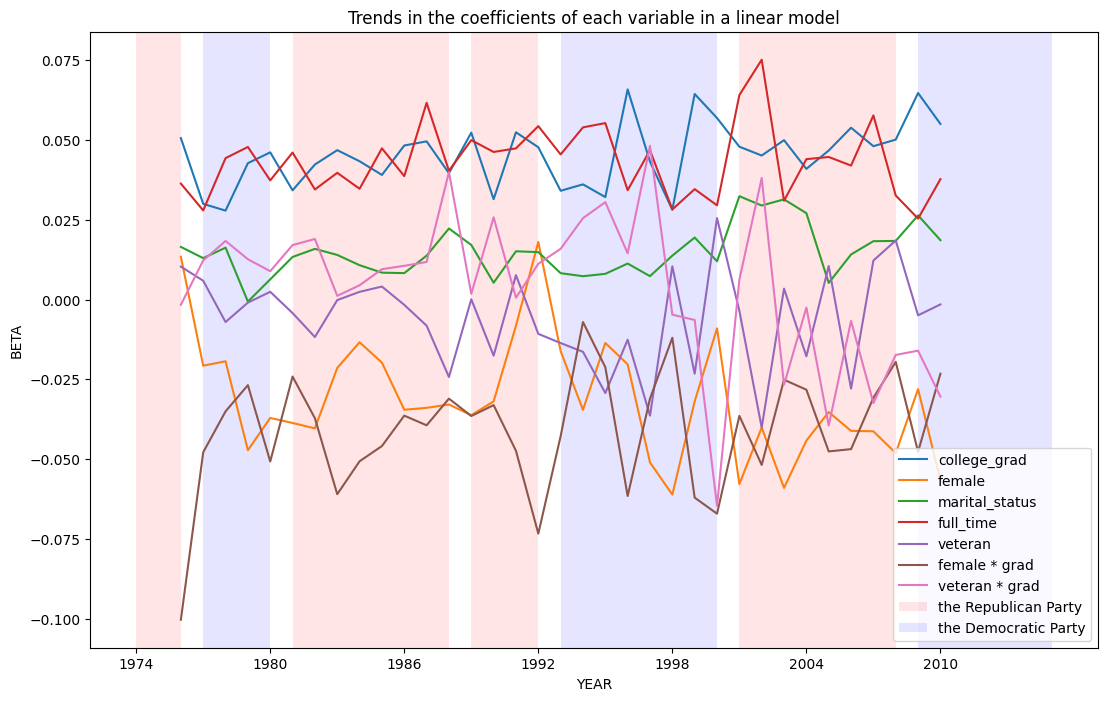


mean : 0.045350186605007205
std : 0.009762647136822193
max : 0.0658378146721712
min : 0.027867895262198024


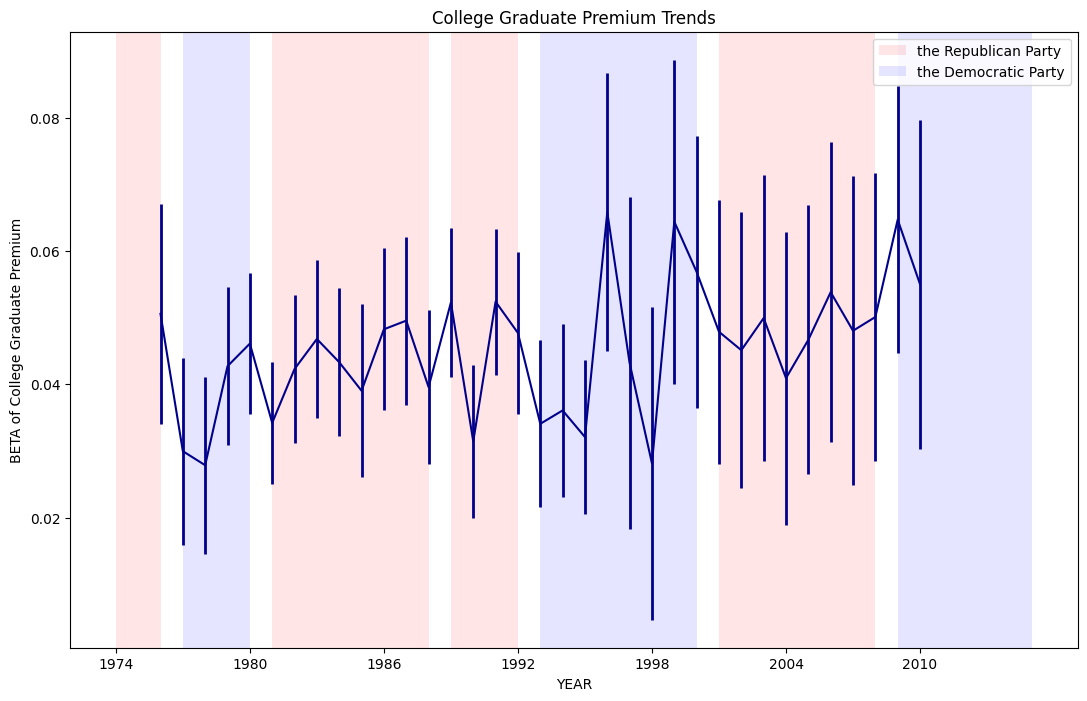

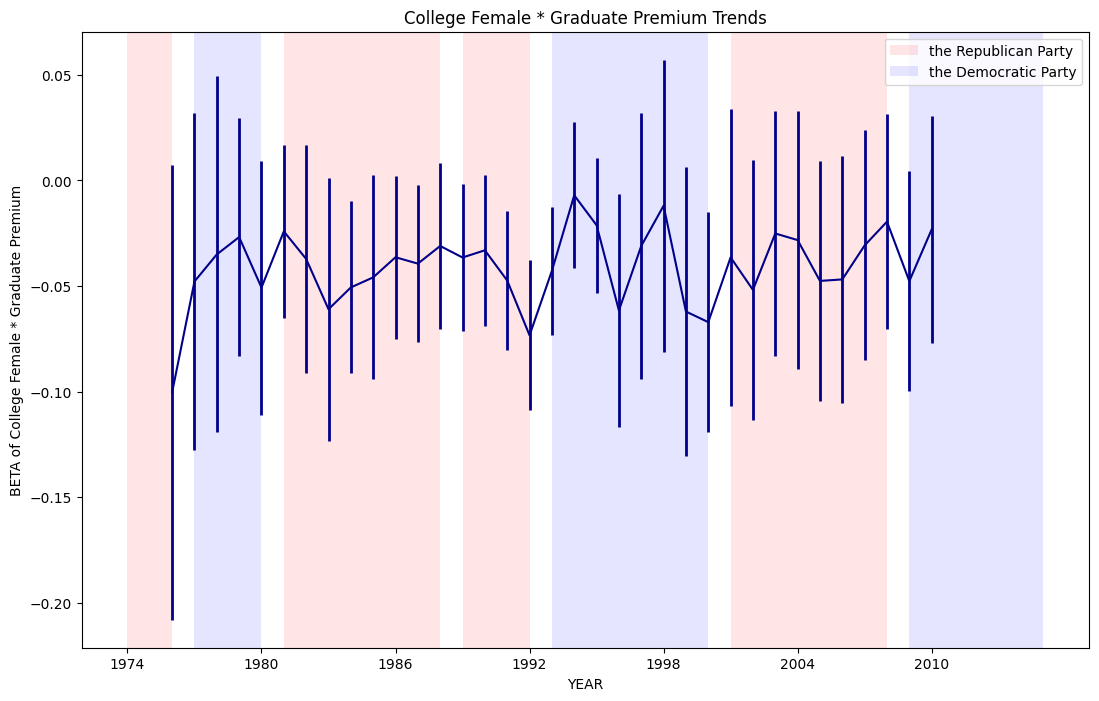

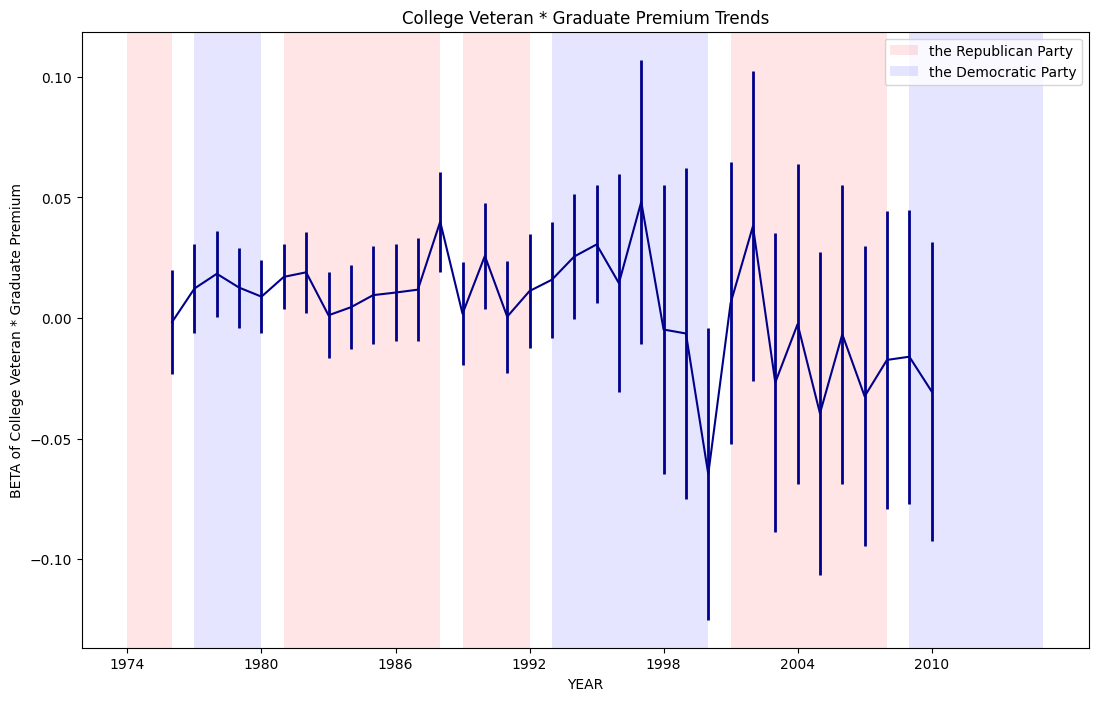

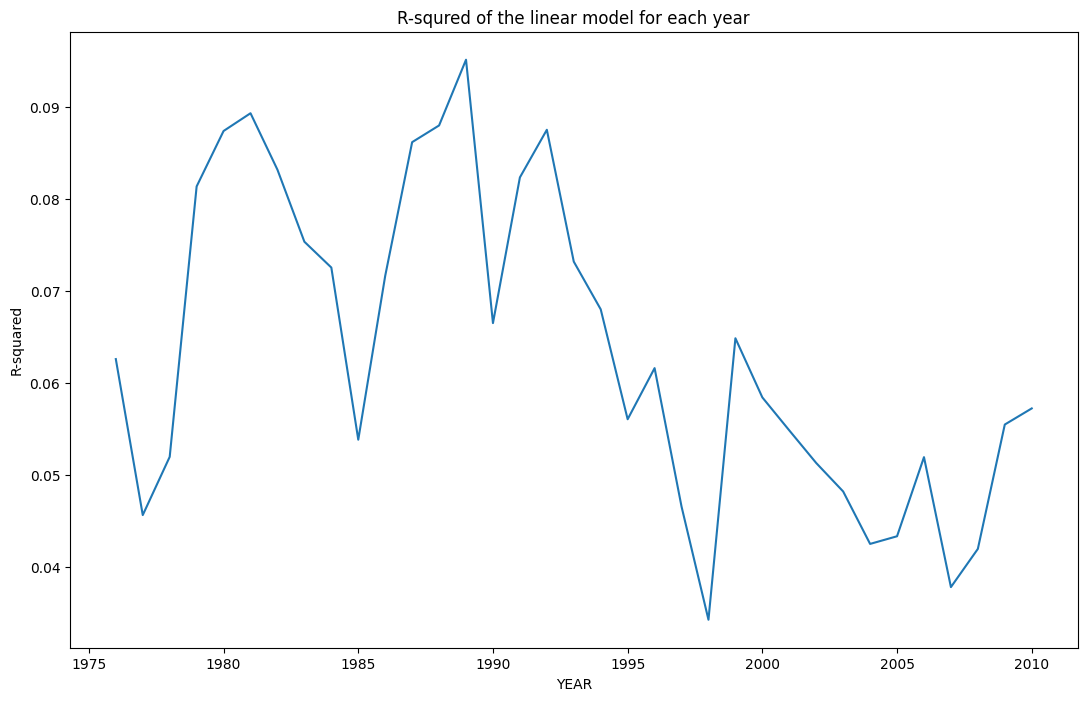

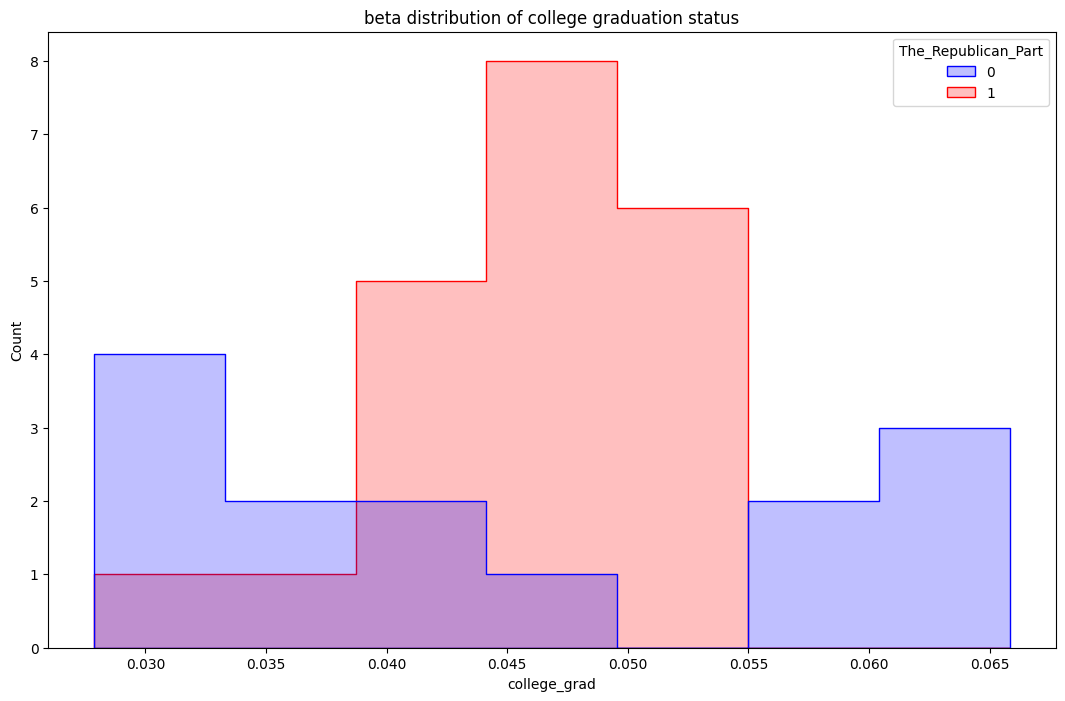

In [200]:
high_log_weekly_earn, high_log_weekly_VIF = regression_analysis(data=data,
                                                              target='log_weekly_earn',
                                                              top_level=0.10,
                                                              bottom_level=None,
                                                              summary=False)

In [201]:
display(high_log_weekly_VIF)

,Intercept,college_grad,female,marital_status,full_time,veteran,female * grad,veteran * grad
1976,19.7432,2.9315,2.3945,1.0662,1.0744,2.2866,2.5602,2.5355
1977,20.1958,2.8094,2.3390,1.0517,1.0685,2.2364,2.5230,2.4382
1978,19.4417,2.6833,2.2743,1.0547,1.0794,2.1337,2.5186,2.3016
1979,18.6455,2.6045,2.2010,1.0392,1.0702,2.1011,2.4959,2.2866
1980,18.8952,2.5640,2.1809,1.0392,1.0673,2.0609,2.5407,2.2258
1981,18.1068,2.5001,2.1537,1.0371,1.0687,2.0206,2.5244,2.1486
1982,17.3062,2.4187,2.0966,1.0348,1.0590,1.9710,2.4920,2.0862
1983,16.6749,2.4044,2.1475,1.0331,1.0581,1.9783,2.5800,2.0498
1984,16.7089,2.4016,2.1426,1.0271,1.0569,1.9718,2.6473,2.0552
1985,17.1478,2.3547,2.1035,1.0277,1.0564,1.9411,2.6384,2.0339


### Log Hourly Wage

데이터셋 : log_hourly_wage 상위 0.1%

회귀식 : log_hourly_wage ~ C(college_grad) + C(female) + C(marital_status) + C(full_time) + C(veteran) + C(female_grad) + C(veteran_grad)



  0%|          | 0/35 [00:00<?, ?it/s]

데이터셋 크기 : 2927



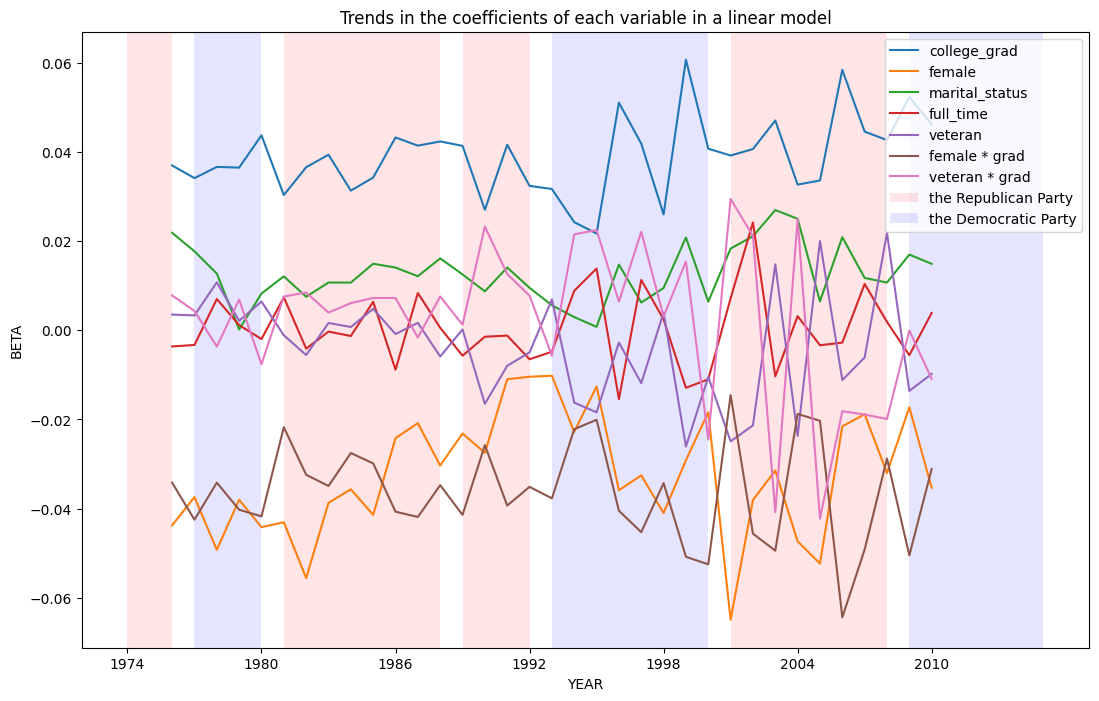


mean : 0.03895914700042628
std : 0.008635253285760789
max : 0.06065026352489676
min : 0.021678320430858596


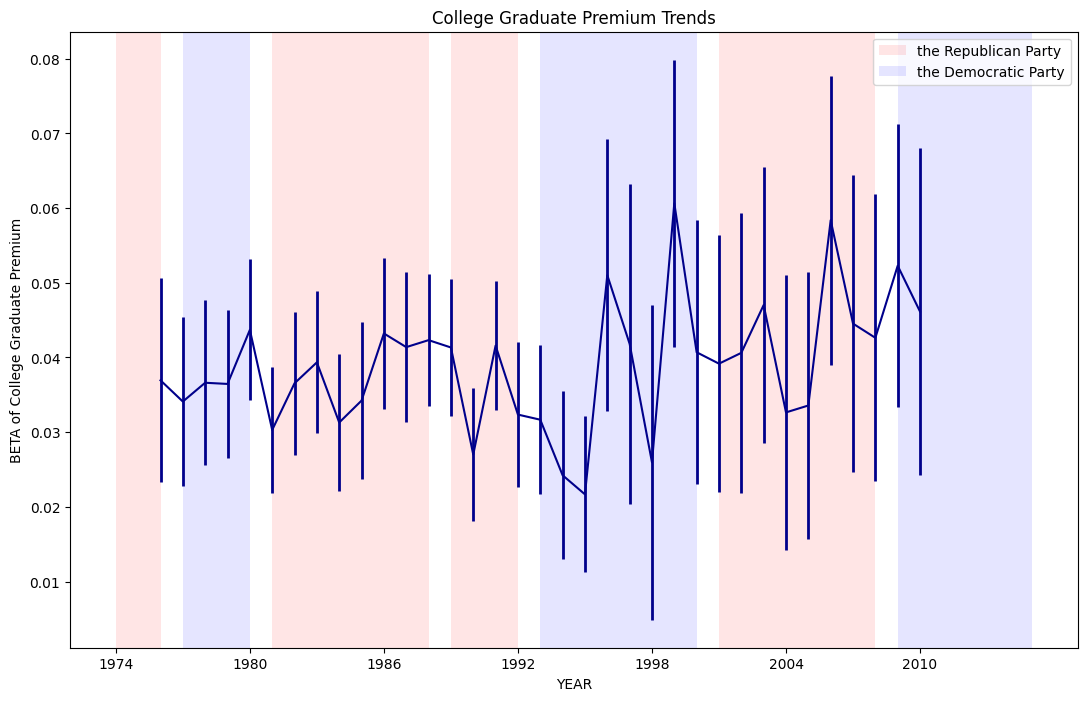

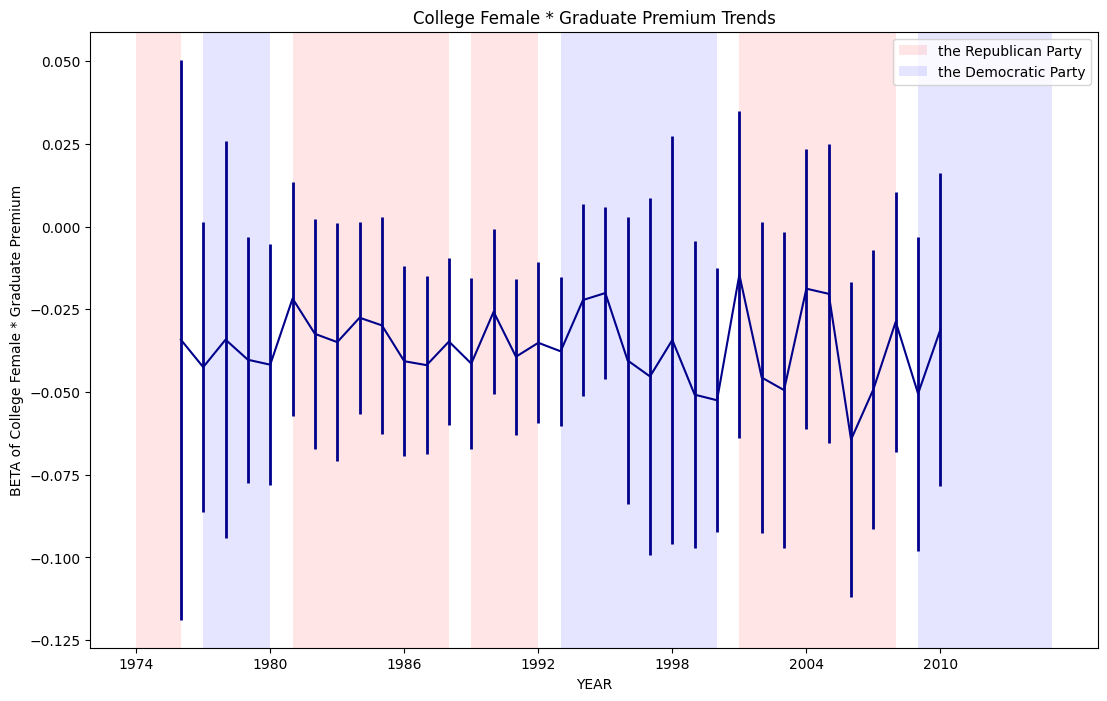

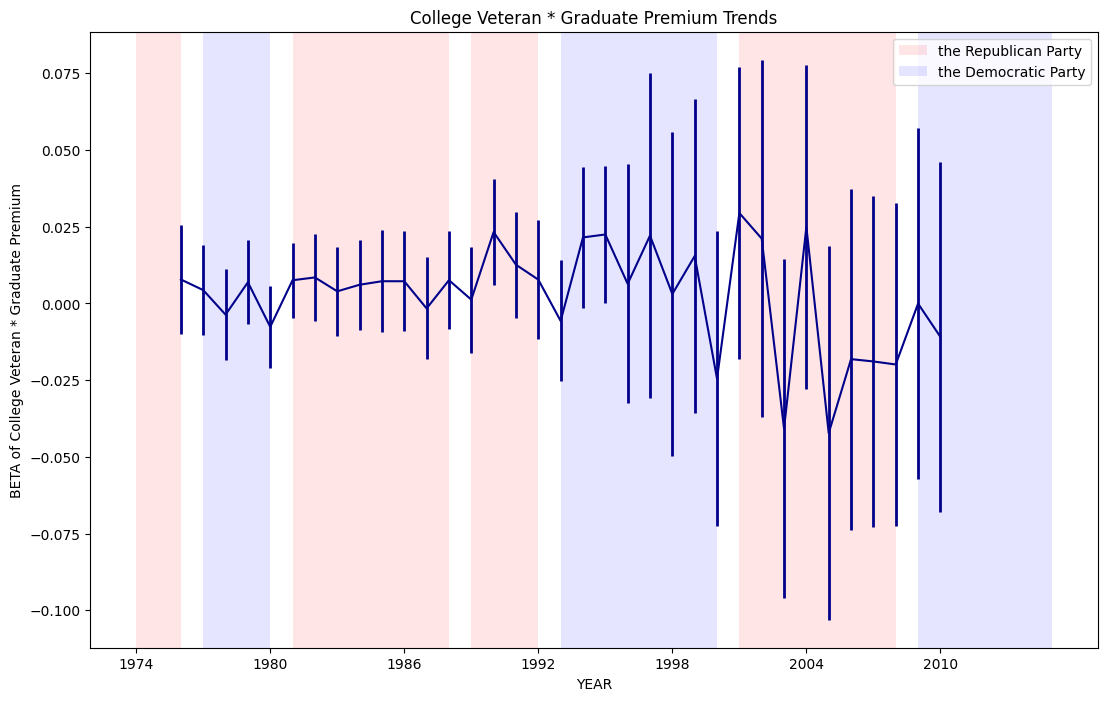

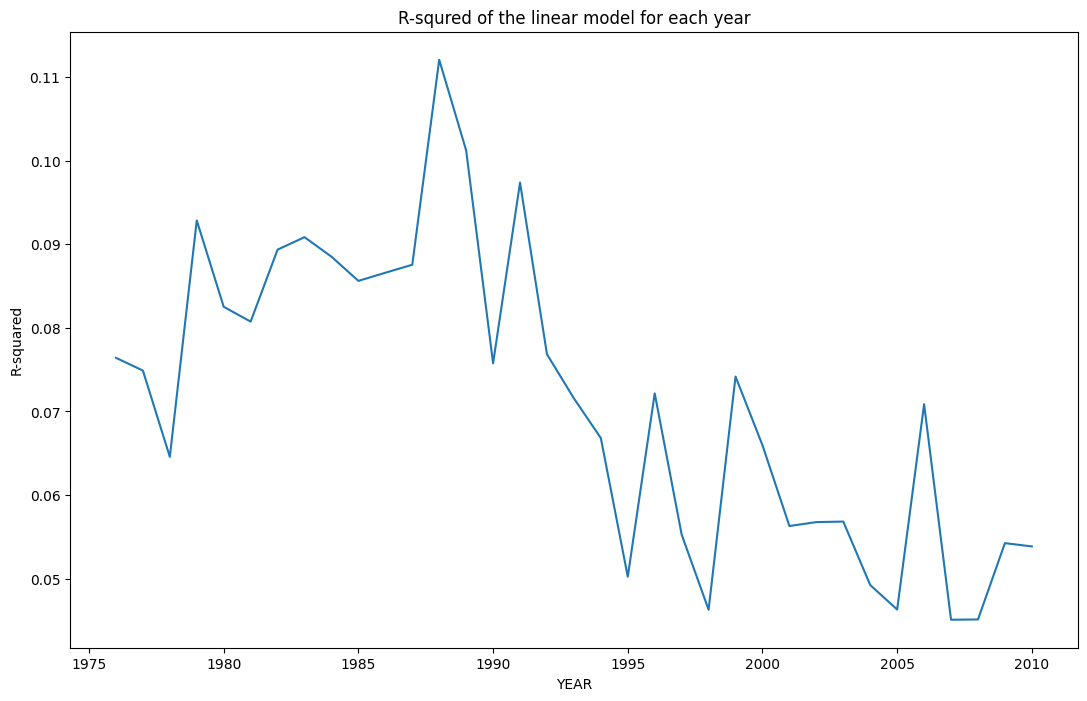

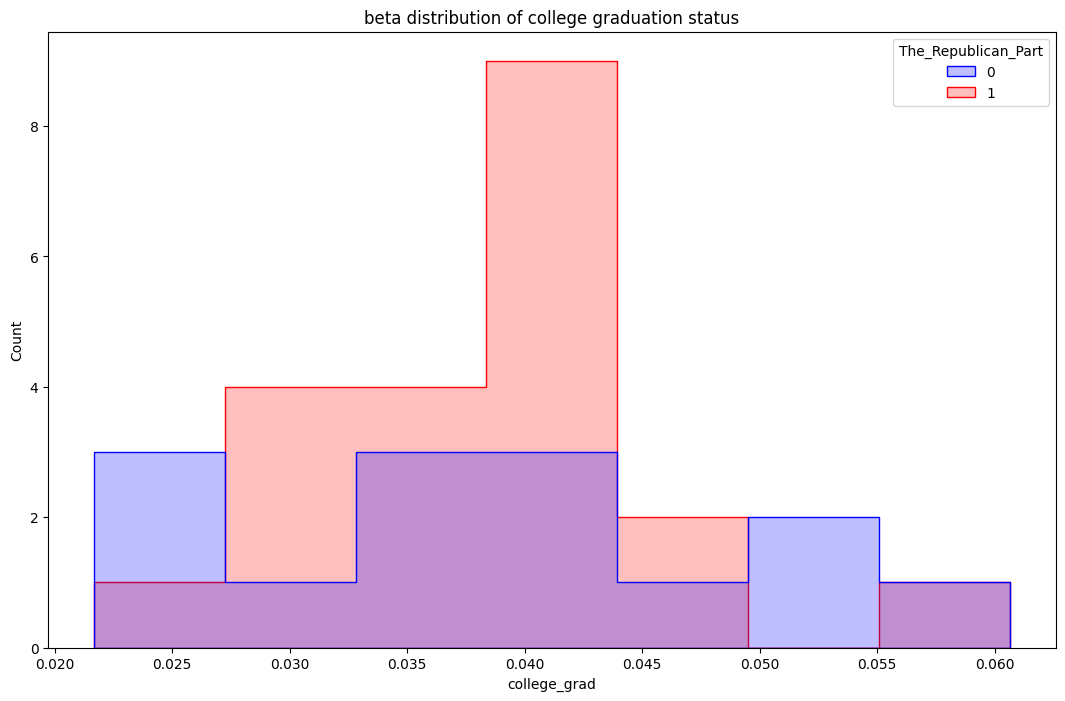

In [203]:
high_log_hourly_wage, high_log_hourly_VIF = regression_analysis(data=data,
                                                              target='log_hourly_wage',
                                                              top_level=0.10,
                                                              bottom_level=None,
                                                              summary=False)

In [204]:
display(high_log_hourly_VIF)

,Intercept,college_grad,female,marital_status,full_time,veteran,female * grad,veteran * grad
1976,19.7432,2.9315,2.3945,1.0662,1.0744,2.2866,2.5602,2.5355
1977,20.1958,2.8094,2.3390,1.0517,1.0685,2.2364,2.5230,2.4382
1978,19.4417,2.6833,2.2743,1.0547,1.0794,2.1337,2.5186,2.3016
1979,18.6455,2.6045,2.2010,1.0392,1.0702,2.1011,2.4959,2.2866
1980,18.8952,2.5640,2.1809,1.0392,1.0673,2.0609,2.5407,2.2258
1981,18.1068,2.5001,2.1537,1.0371,1.0687,2.0206,2.5244,2.1486
1982,17.3062,2.4187,2.0966,1.0348,1.0590,1.9710,2.4920,2.0862
1983,16.6749,2.4044,2.1475,1.0331,1.0581,1.9783,2.5800,2.0498
1984,16.7089,2.4016,2.1426,1.0271,1.0569,1.9718,2.6473,2.0552
1985,17.1478,2.3547,2.1035,1.0277,1.0564,1.9411,2.6384,2.0339


## 하위 10%

### Log Weekly Earn

데이터셋 : log_weekly_earn 하위 0.1%

회귀식 : log_weekly_earn ~ C(college_grad) + C(female) + C(marital_status) + C(full_time) + C(veteran) + C(female_grad) + C(veteran_grad)



  0%|          | 0/35 [00:00<?, ?it/s]

데이터셋 크기 : 2947



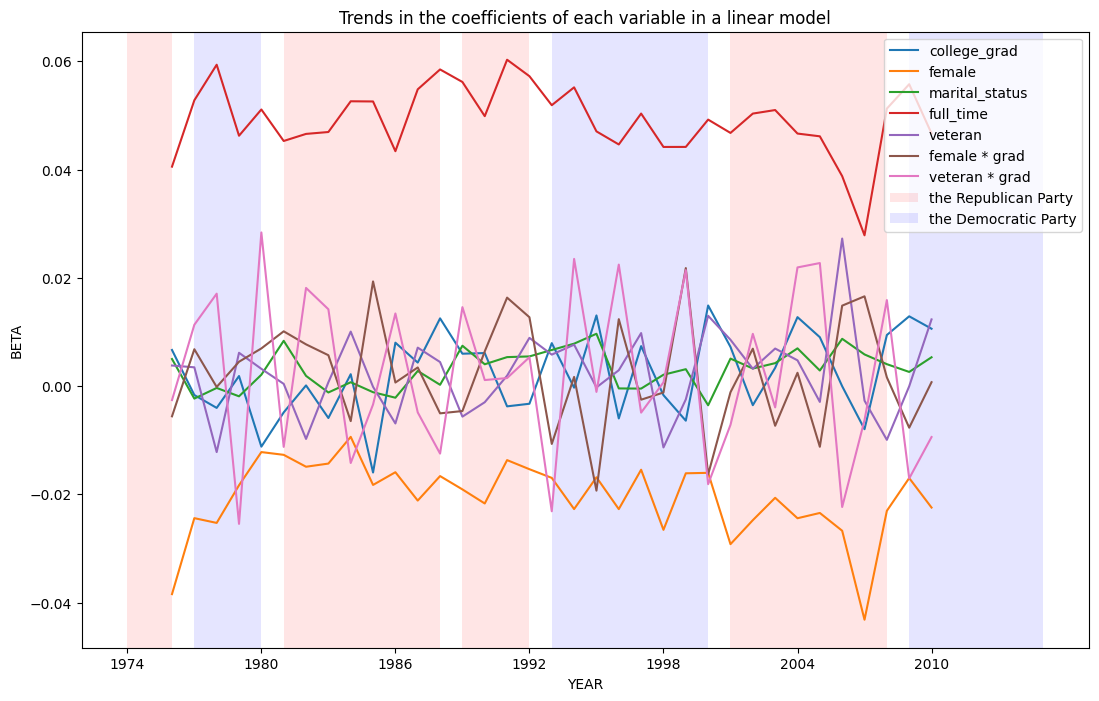


mean : 0.002280167558358847
std : 0.007567190076296441
max : 0.014882673012403152
min : -0.01596623253220949


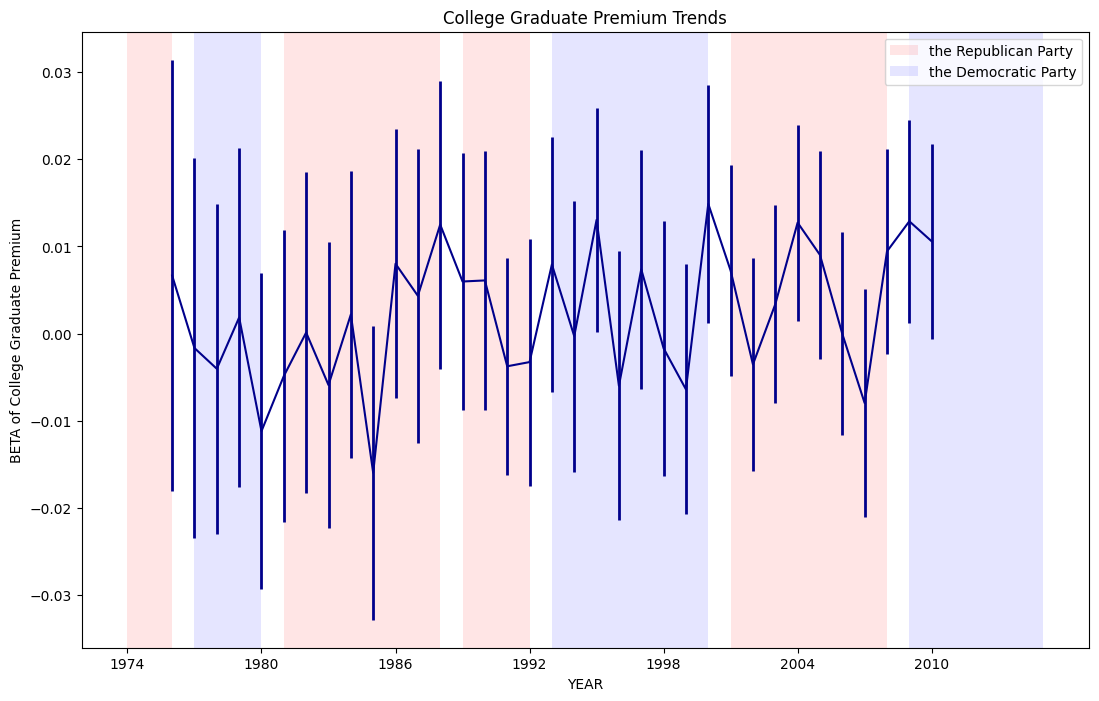

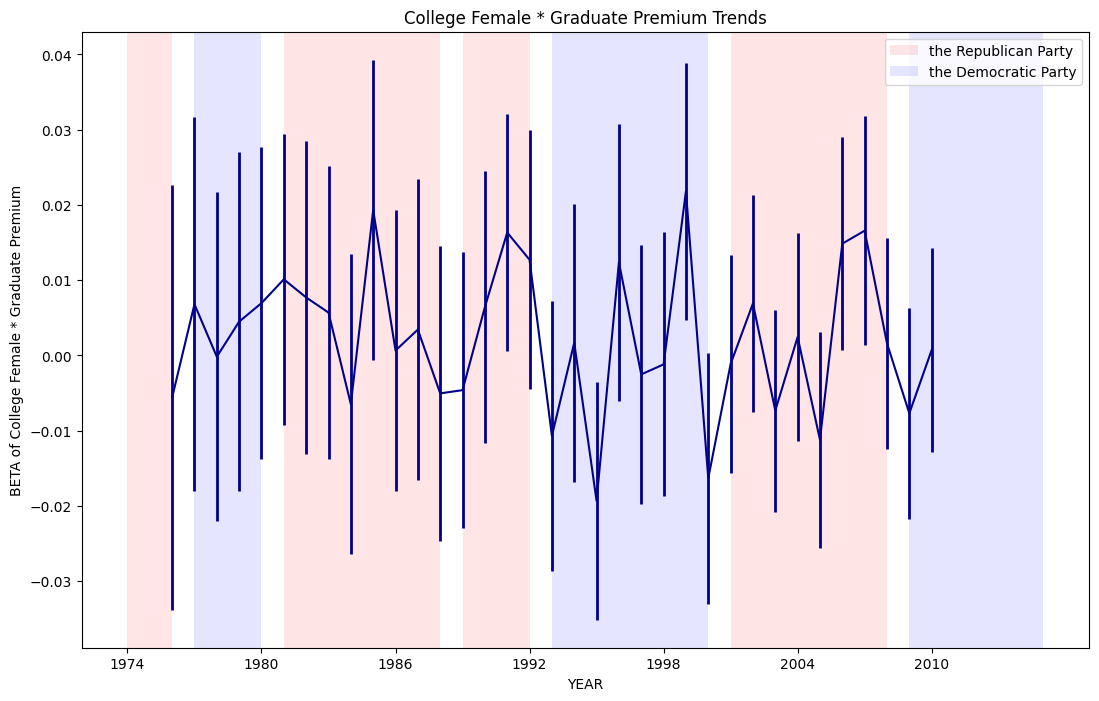

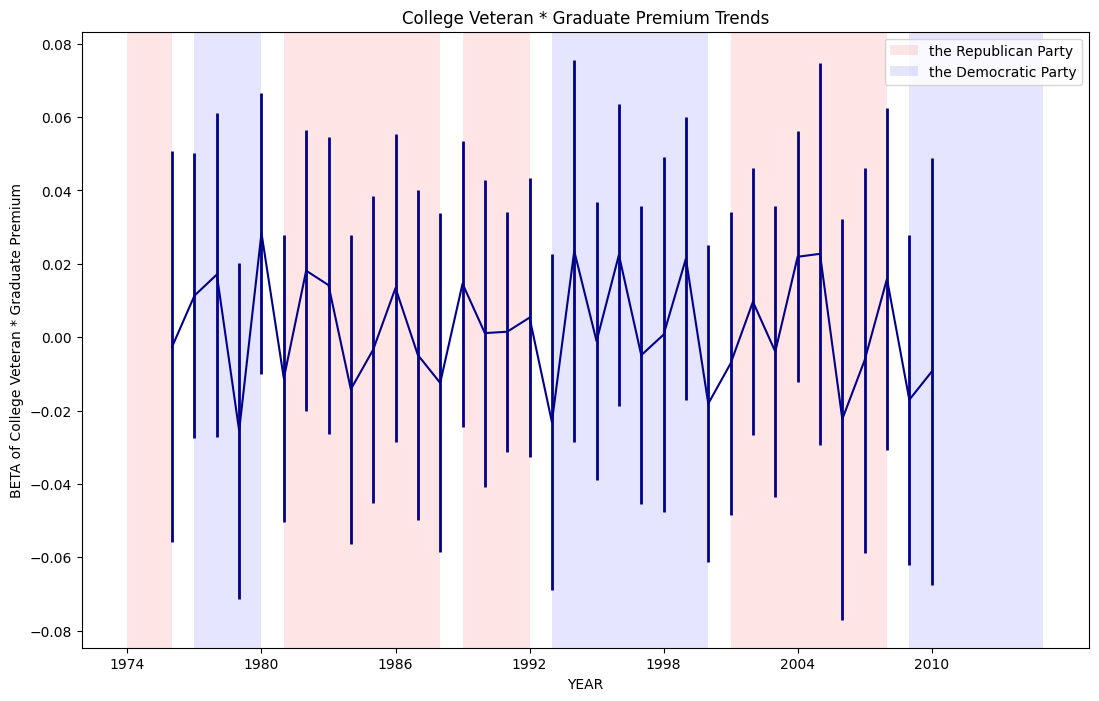

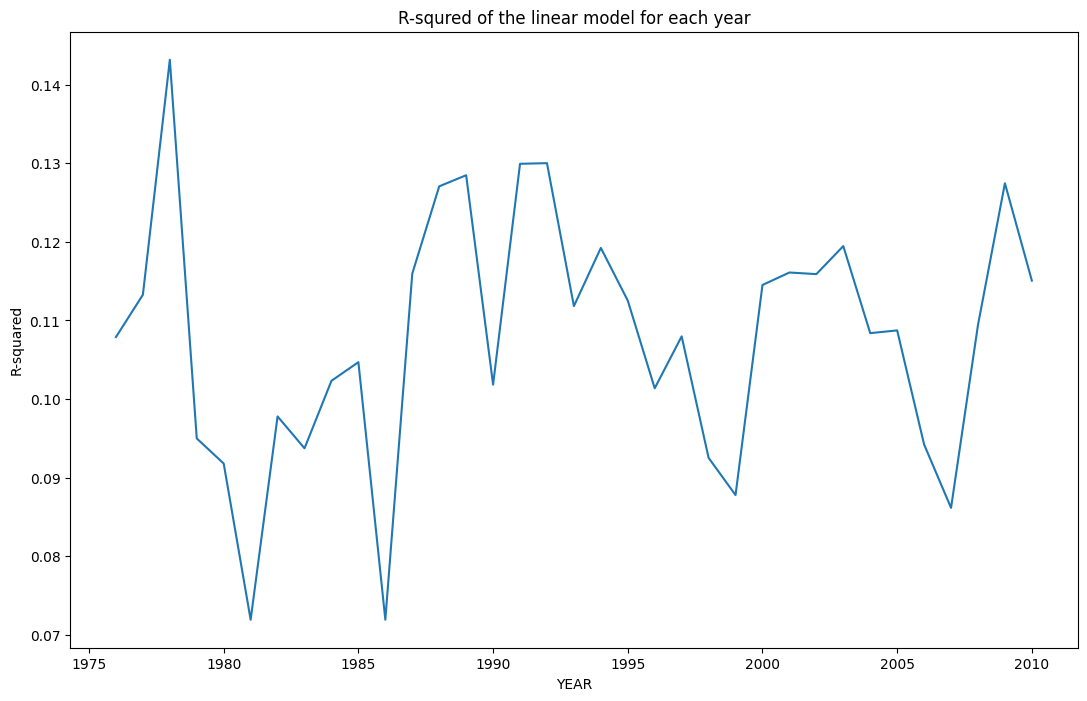

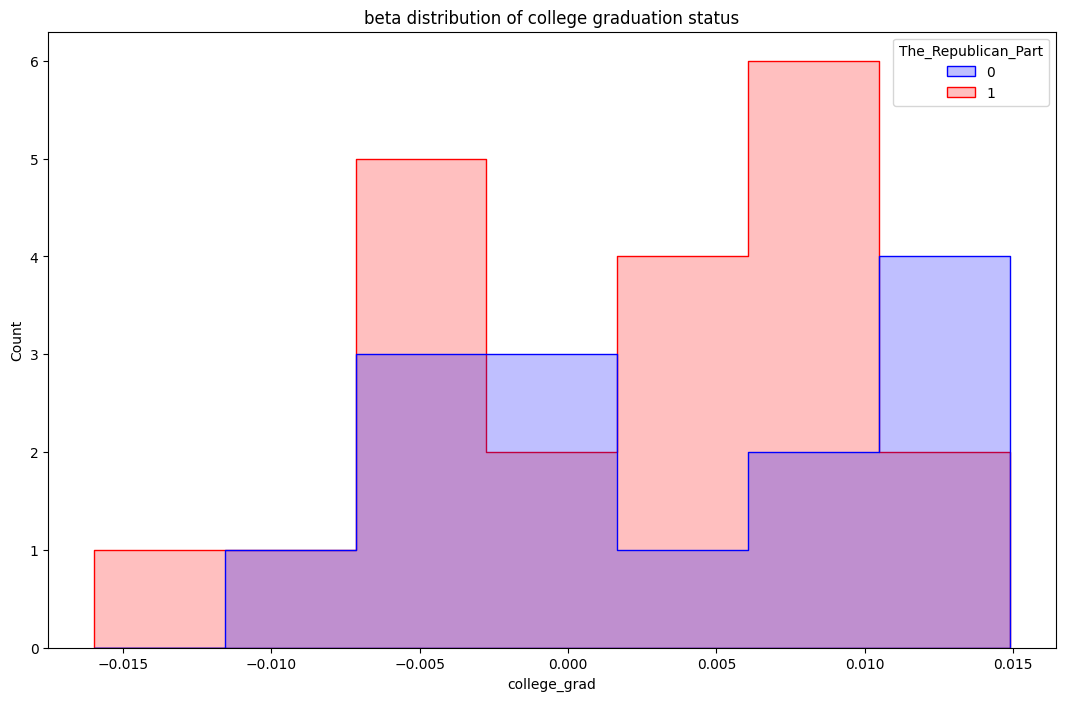

In [205]:
low_log_weekly_earn, low_log_weekly_VIF = regression_analysis(data=data,
                                                              target='log_weekly_earn',
                                                              top_level=None,
                                                              bottom_level=0.10,
                                                              summary=False)

In [206]:
display(low_log_weekly_VIF)

,Intercept,college_grad,female,marital_status,full_time,veteran,female * grad,veteran * grad
1976,19.7432,2.9315,2.3945,1.0662,1.0744,2.2866,2.5602,2.5355
1977,20.1958,2.8094,2.3390,1.0517,1.0685,2.2364,2.5230,2.4382
1978,19.4417,2.6833,2.2743,1.0547,1.0794,2.1337,2.5186,2.3016
1979,18.6455,2.6045,2.2010,1.0392,1.0702,2.1011,2.4959,2.2866
1980,18.8952,2.5640,2.1809,1.0392,1.0673,2.0609,2.5407,2.2258
1981,18.1068,2.5001,2.1537,1.0371,1.0687,2.0206,2.5244,2.1486
1982,17.3062,2.4187,2.0966,1.0348,1.0590,1.9710,2.4920,2.0862
1983,16.6749,2.4044,2.1475,1.0331,1.0581,1.9783,2.5800,2.0498
1984,16.7089,2.4016,2.1426,1.0271,1.0569,1.9718,2.6473,2.0552
1985,17.1478,2.3547,2.1035,1.0277,1.0564,1.9411,2.6384,2.0339


### Log Hourly Wage

데이터셋 : log_hourly_wage 하위 0.1%

회귀식 : log_hourly_wage ~ C(college_grad) + C(female) + C(marital_status) + C(full_time) + C(veteran) + C(female_grad) + C(veteran_grad)



  0%|          | 0/35 [00:00<?, ?it/s]

데이터셋 크기 : 2928



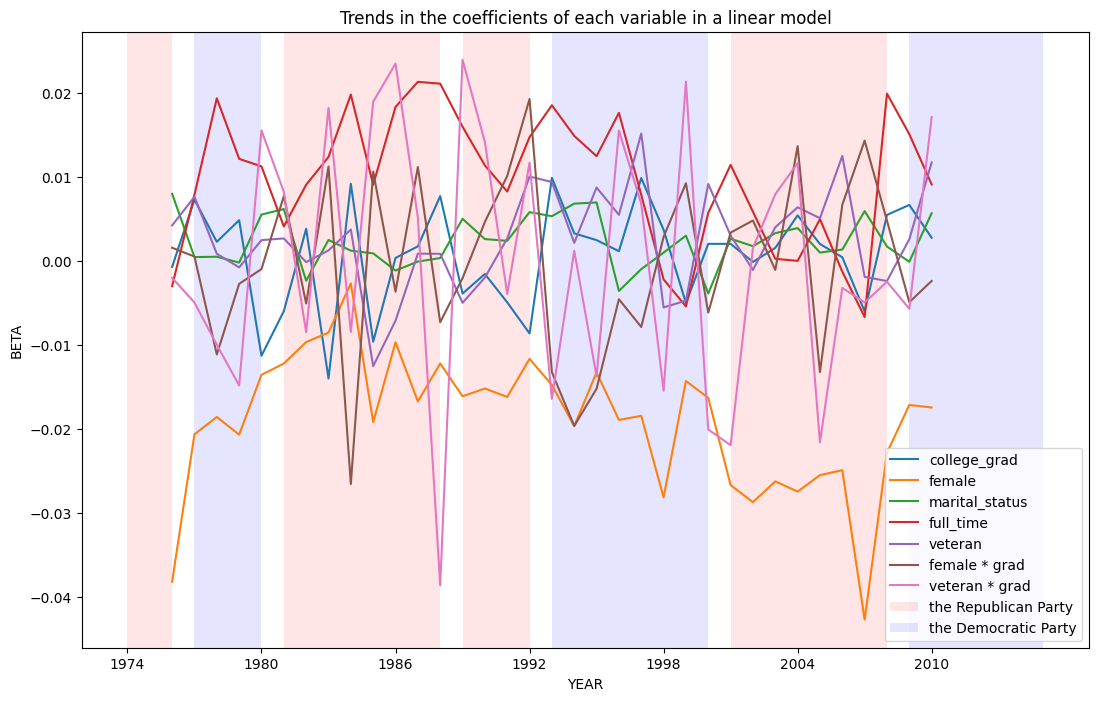


mean : 0.0006567352099180655
std : 0.005881010769238501
max : 0.00985418374508914
min : -0.014035618804891865


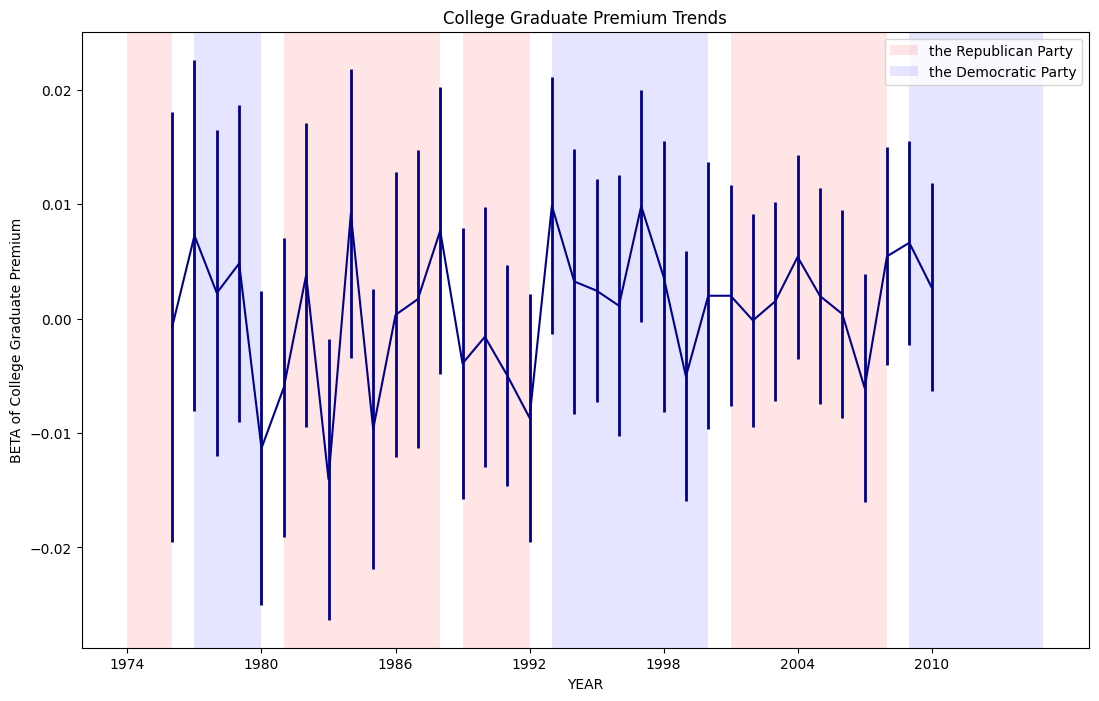

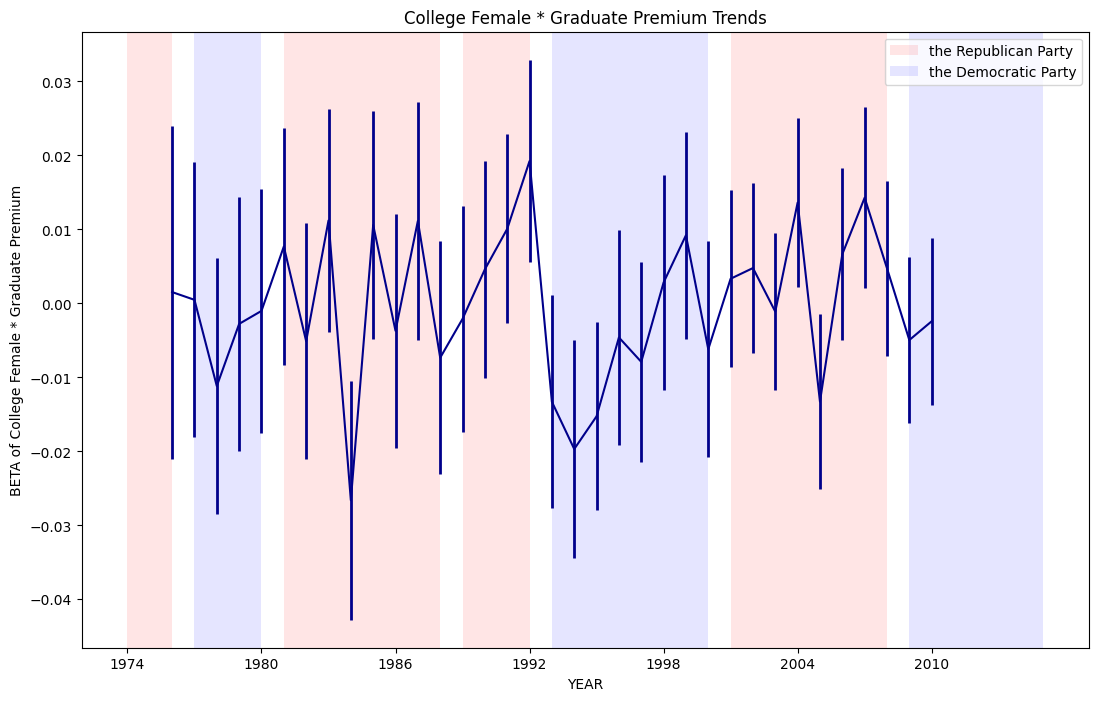

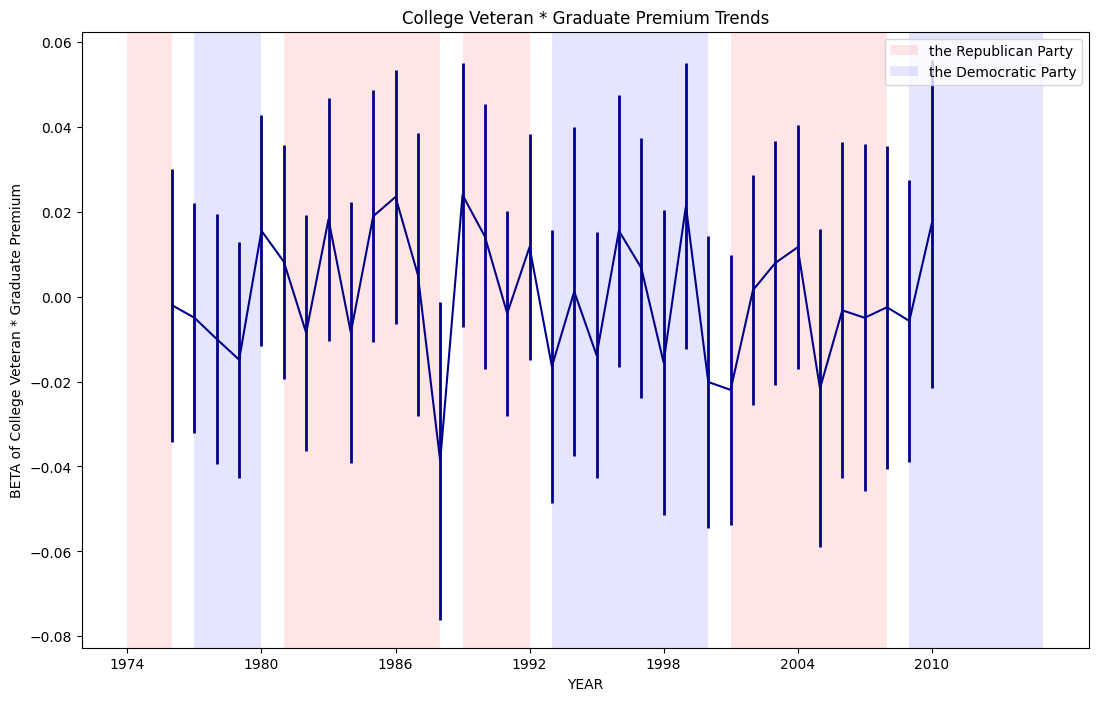

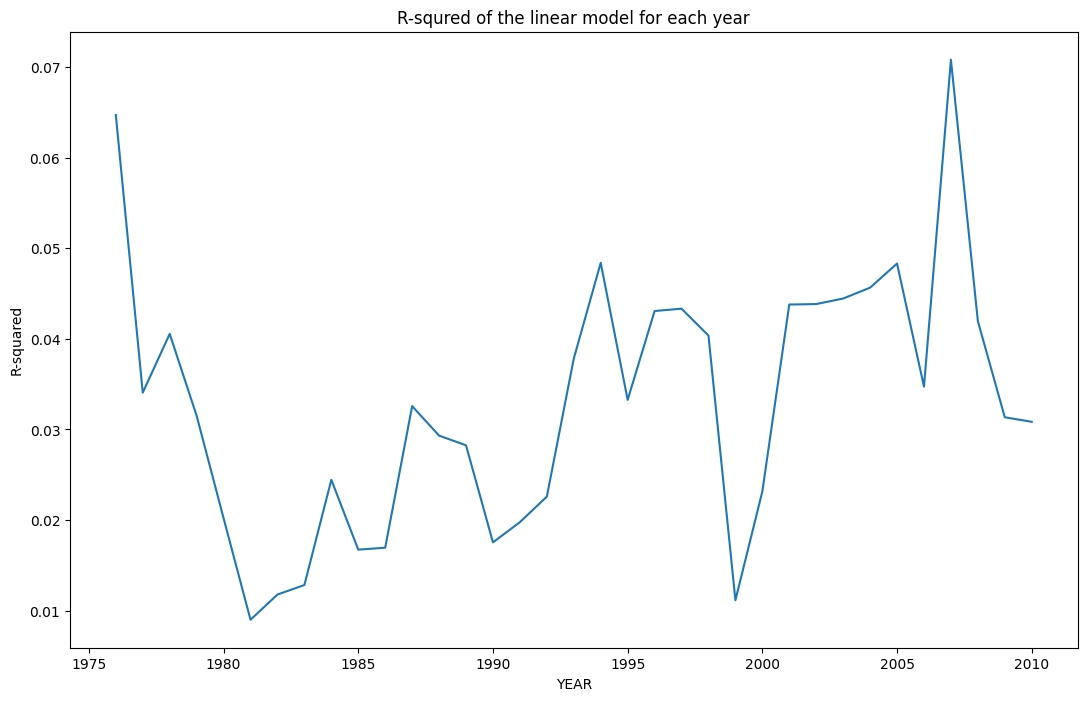

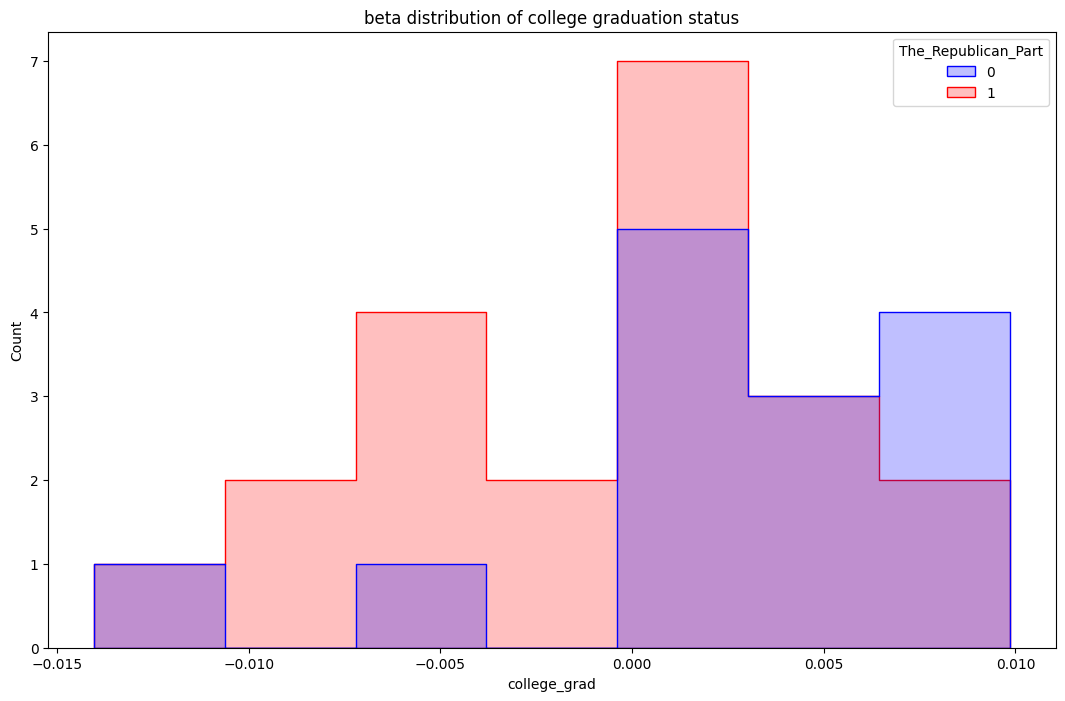

In [207]:
low_log_hourly_wage, low_log_hourly_VIF = regression_analysis(data=data,
                                                              target='log_hourly_wage',
                                                              top_level=None,
                                                              bottom_level=0.10,
                                                              summary=False)

In [208]:
display(low_log_hourly_VIF)

,Intercept,college_grad,female,marital_status,full_time,veteran,female * grad,veteran * grad
1976,19.7432,2.9315,2.3945,1.0662,1.0744,2.2866,2.5602,2.5355
1977,20.1958,2.8094,2.3390,1.0517,1.0685,2.2364,2.5230,2.4382
1978,19.4417,2.6833,2.2743,1.0547,1.0794,2.1337,2.5186,2.3016
1979,18.6455,2.6045,2.2010,1.0392,1.0702,2.1011,2.4959,2.2866
1980,18.8952,2.5640,2.1809,1.0392,1.0673,2.0609,2.5407,2.2258
1981,18.1068,2.5001,2.1537,1.0371,1.0687,2.0206,2.5244,2.1486
1982,17.3062,2.4187,2.0966,1.0348,1.0590,1.9710,2.4920,2.0862
1983,16.6749,2.4044,2.1475,1.0331,1.0581,1.9783,2.5800,2.0498
1984,16.7089,2.4016,2.1426,1.0271,1.0569,1.9718,2.6473,2.0552
1985,17.1478,2.3547,2.1035,1.0277,1.0564,1.9411,2.6384,2.0339


# Appendix

In [223]:
aw = all_log_weekly_earn[['R2']]
ah = all_log_hourly_wage[['R2']]
aw.columns = ['log(weekly earns)']
ah.columns = ['log(hourly wages)']

hw = high_log_weekly_earn[['R2']]
hh = high_log_hourly_wage[['R2']]
hw.columns = ['high log(weekly earns)']
hh.columns = ['high log(hourly wages)']

lw =low_log_weekly_earn[['R2']]
lh = low_log_hourly_wage[['R2']]
lw.columns = ['high log(weekly earns)']
lh.columns = ['low log(hourly wages)']

R2 = pd.concat([aw, ah, hw, hh, lw, lh], axis=1)
R2.index = [1976+i for i in range(35)]

In [224]:
display(R2)

,log(weekly earns),log(hourly wages),high log(weekly earns),high log(hourly wages),high log(weekly earns),low log(hourly wages)
1976,0.3971,0.3200,0.0626,0.0764,0.1079,0.0647
1977,0.3652,0.2818,0.0457,0.0749,0.1133,0.0341
1978,0.3605,0.2815,0.0520,0.0646,0.1432,0.0405
1979,0.3592,0.2809,0.0814,0.0928,0.0950,0.0315
1980,0.3494,0.2747,0.0874,0.0825,0.0918,0.0202
1981,0.3466,0.2707,0.0893,0.0807,0.0719,0.0090
1982,0.3399,0.2697,0.0832,0.0893,0.0978,0.0118
1983,0.3358,0.2635,0.0753,0.0908,0.0937,0.0128
1984,0.3224,0.2510,0.0725,0.0885,0.1023,0.0244
1985,0.3290,0.2577,0.0539,0.0856,0.1047,0.0167
